# **Part 2**

## **Model Building - Approach**
1. Data preparation
2. Partition the data into train and test set
3. Fit on the train data
4. Tune the model and prune the tree, if required
5. Test the model on test set

## **Data Preparation**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import scipy.stats as si
import random
import math

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_predict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,ReLU,BatchNormalization,InputLayer
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('dataWithoutOutliers.csv') # Loading data with outlier treatment
obj_cols=[col for col in data.columns if data.loc[:,col].dtype=='object'] # Converting object types to categories
data[obj_cols]=data[obj_cols].astype("category")
data.LOAN=data.LOAN.astype("float64")

### **Separating the target variable from other variables**

In [3]:
# Drop the dependent variable from the dataframe and create the X(independent variable) matrix
X=data.drop(columns='BAD')

# Create dummy variables for the categorical variables - Hint: use the get_dummies() function
X=pd.get_dummies(X,drop_first=True)

# Create y(dependent varibale)
Y=data.BAD

### **Data preprocessing and train-test split**

In [4]:
# Defining  a function to perform data preprocessing
def dataPreprocessing(X):
    global y_train,y_test
    # Standardizing data
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(X)

    # Split the data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1, stratify=Y)
    X_train_scaled, X_test_scaled= train_test_split(X_scaled,test_size = 0.30, random_state = 1, stratify=Y)

    # Turning into Data Frames objects
    X_train_scaled,X_test_scaled=pd.DataFrame(X_train_scaled,columns=X.columns),pd.DataFrame(X_test_scaled,columns=X.columns)
    X_train_scaled.index,X_test_scaled.index=X_train.index,X_test.index
    return X_train_scaled,X_test_scaled

Model optimization using all features at the same time performed with gradient-based method requires data standardization in order to avoid to overweight data with values in a larger scale, as well as to speed up convergence.<br>
Furthermore:
<ul>
<li>By using a split of 70:30 models are trained on a smaller portion of data and may capture more noise compared to a 80:20 dataset. However, if the dataset is large enough, this difference is almost negligible. </li>
    <li>The choice of this proportion should consider the number of folders when using cross-validation.</li>
    <li>If the dataset is not large enough and the test is rather small, sometimes neural networks give better learning curver on test set than on train set.</li>
    <li>Data is split with stratification in order to retain the proportionality of samples based on <b>BAD</b> category after the split.</li>
</ul>


## **Model Evaluation Criterion**

In [5]:
#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

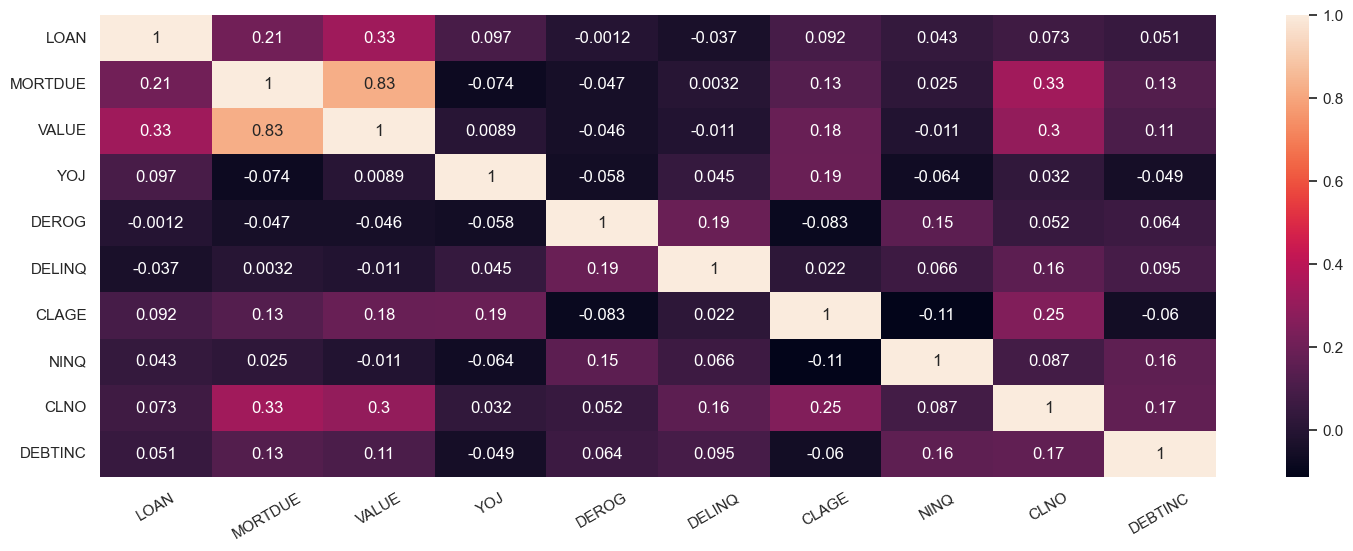

In [6]:
num_columns=[]
for column in data.columns:
    if data[column].dtype=="float64":
        num_columns.append(column)  


fig = plt.figure(figsize = (18, 6))
sns.heatmap(data[num_columns].corr(), annot = True);
plt.xticks(rotation = 30);

### **Build a Logistic Regression Model** 

In [7]:
X_train_scaled,X_test_scaled=dataPreprocessing(X)

# Defining the Logistic regression model
lg1=LogisticRegression(class_weight={0:y_train.value_counts(normalize=1)[1],1:y_train.value_counts(normalize=1)[0]},random_state=12)

# Fitting the model on the training data 
lg1.fit(X_train_scaled,y_train)

LogisticRegression(class_weight={0: 0.19942473633748803, 1: 0.800575263662512},
                   random_state=12)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      3340
           1       0.63      0.83      0.72       832

    accuracy                           0.87      4172
   macro avg       0.79      0.86      0.82      4172
weighted avg       0.89      0.87      0.88      4172



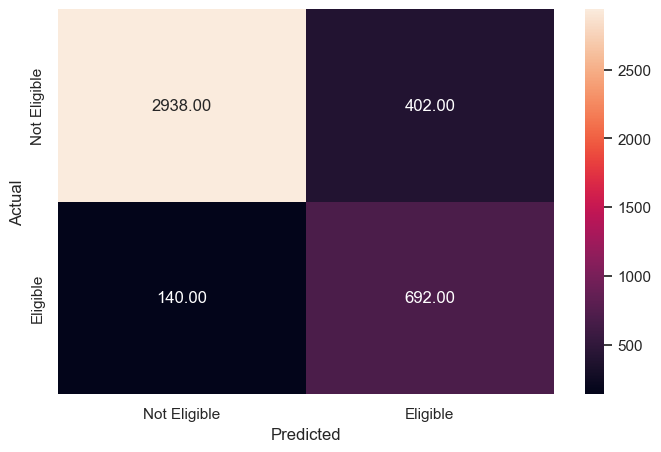

In [8]:
#Predict for train set
y_pred_train1=lg1.predict(X_train_scaled)

# Checking the performance on the train dataset
metrics_score(y_train,y_pred_train1)

The main metric of interest is Recall which is 83% on the training data, Precision is only 63%

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1431
           1       0.64      0.81      0.72       357

    accuracy                           0.87      1788
   macro avg       0.79      0.85      0.82      1788
weighted avg       0.89      0.87      0.88      1788



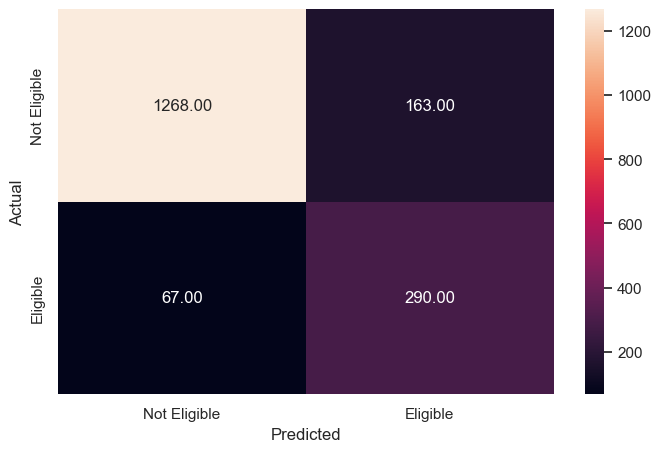

In [9]:
#Predict for test set
y_pred_test1=lg1.predict(X_test_scaled)

#checking the performance on the test dataset
metrics_score(y_test,y_pred_test1)

<um>
 <li>The default Logistic Regression model performs simlarly on train and test set, the problem of overfitting is not there.</li>
    <li>The correlation of <b>VALUE</b>and <b>MORTDUE</b> is beyond 0,8. Let's rerun the model to check whether we can drop one of the two as they may carry similar information.</li>
</um>

In [10]:
X_=X.copy()
X_=X_.drop(columns="MORTDUE") # better to drop MORTDUE as it had more missing values than VALUE

X_train_scaled_,X_test_scaled_=dataPreprocessing(X_)

# Defining the Logistic regression model
lg2=LogisticRegression(class_weight={0:y_train.value_counts(normalize=1)[1],1:y_train.value_counts(normalize=1)[0]},random_state=12)

# Fitting the model on the training data 
lg2.fit(X_train_scaled_,y_train)

LogisticRegression(class_weight={0: 0.19942473633748803, 1: 0.800575263662512},
                   random_state=12)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      3340
           1       0.63      0.83      0.71       832

    accuracy                           0.87      4172
   macro avg       0.79      0.85      0.81      4172
weighted avg       0.89      0.87      0.87      4172



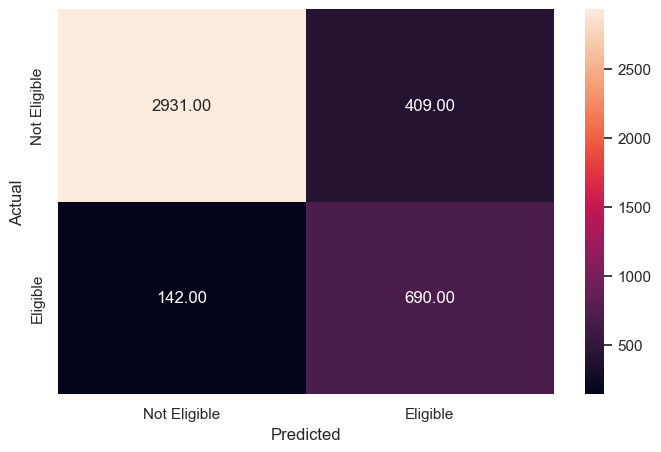

In [11]:
#Predict for train set
y_pred_train1=lg2.predict(X_train_scaled_)

# Checking the performance on the train dataset
metrics_score(y_train,y_pred_train1)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1431
           1       0.64      0.81      0.72       357

    accuracy                           0.87      1788
   macro avg       0.79      0.85      0.82      1788
weighted avg       0.89      0.87      0.88      1788



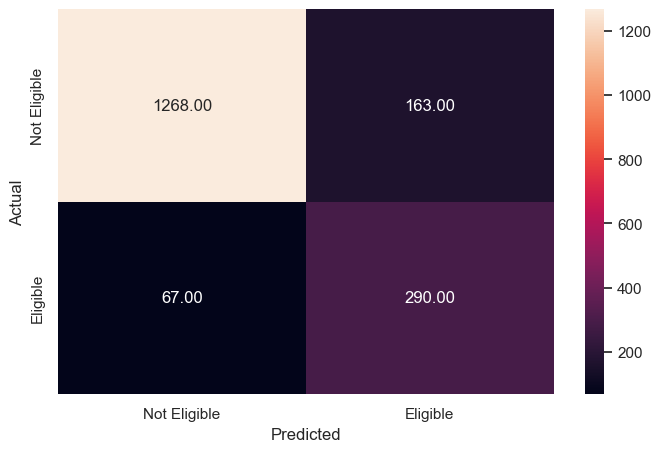

In [12]:
#Predict for test set
y_pred_test1=lg2.predict(X_test_scaled_)

#checking the performance on the test dataset
metrics_score(y_test,y_pred_test1)

<ul>
    <li>The model without <b>MORTDUE</b> has exactly the same performance of the previous one. With the same performance performance, the simpler model should be preferred.</li>
    <li>However, there are still 26 predictors. Let's check the statistic in order to detect whether all variables are relevant or not.</li>
</ul>

In [13]:
logit_model1=sm.Logit(y_train,X_train_scaled_).fit()
print(logit_model1.summary())

Optimization terminated successfully.
         Current function value: 0.364587
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4172
Model:                          Logit   Df Residuals:                     4146
Method:                           MLE   Df Model:                           25
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                  0.2702
Time:                        14:40:40   Log-Likelihood:                -1521.1
converged:                       True   LL-Null:                       -2084.3
Covariance Type:            nonrobust   LLR p-value:                7.446e-222
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
LOAN                           -0.0389      0.054     -0.716      0.474   

From the statistics above, it seems that with the confidence level of 95% the following features are NOT significant: <b>LOAN</b>, <b>VALUE</b>, <b>REASON_missing_values_flag</b>, <b>DELINQ_missing_values_flag</b>, <b>CLAGE_missing_values_flag</b>, <b>NINQ_missing_values_flag</b>, <b>REASON_HomeImp</b>, <b>JOB_Other </b>, <b>JOB_ProfExe</b> and <b>JOB_Self</b>

In [14]:
logit_model1Feat=["YOJ","DEROG","DELINQ","CLAGE","NINQ","CLNO","DEBTINC","MORTDUE_missing_values_flag",
                  "VALUE_missing_values_flag","JOB_missing_values_flag","YOJ_missing_values_flag",
                  "DEROG_missing_values_flag","CLNO_missing_values_flag","DEBTINC_missing_values_flag","JOB_Office","JOB_Sales"]

In [15]:
X_train_scaled__,X_test_scaled__=dataPreprocessing(X[logit_model1Feat])
# Defining the Logistic regression model
lg3=LogisticRegression(class_weight={0:y_train.value_counts(normalize=1)[1],1:y_train.value_counts(normalize=1)[0]},random_state=12)

# Fitting the model on the training data 
lg3.fit(X_train_scaled__,y_train)

LogisticRegression(class_weight={0: 0.19942473633748803, 1: 0.800575263662512},
                   random_state=12)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3340
           1       0.62      0.82      0.71       832

    accuracy                           0.86      4172
   macro avg       0.79      0.85      0.81      4172
weighted avg       0.89      0.86      0.87      4172



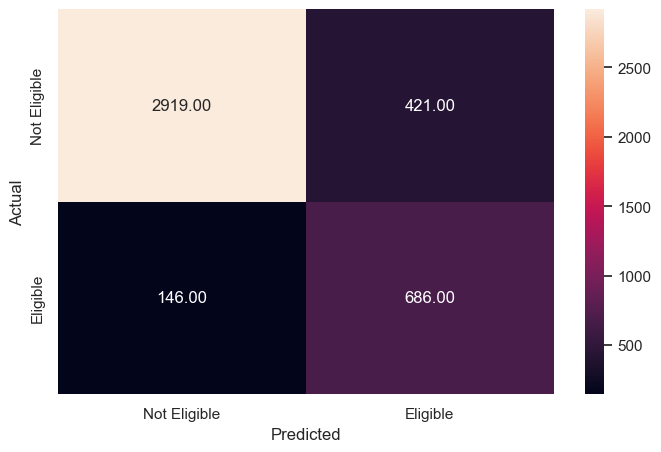

In [16]:
#Predict for train set
y_pred_train1=lg3.predict(X_train_scaled__)

# Checking the performance on the train dataset
metrics_score(y_train,y_pred_train1)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1431
           1       0.62      0.81      0.70       357

    accuracy                           0.86      1788
   macro avg       0.79      0.84      0.81      1788
weighted avg       0.88      0.86      0.87      1788



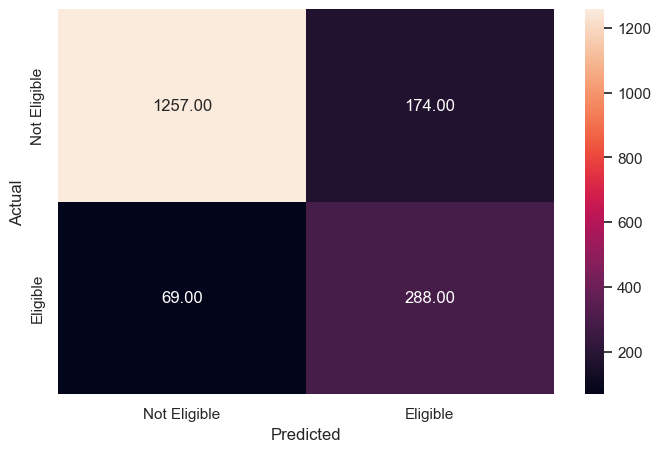

In [17]:
#Predict for test set
y_pred_test1=lg3.predict(X_test_scaled__)

#checking the performance on the test dataset
metrics_score(y_test,y_pred_test1)

<ul>
<li>On test set, Recall is still the same and Precision decreases by only 2%, which means that there were many variables giving low contribution to prediction.</li>
<li>The model is capable of about the same performance with less complexity, from 26 feature to just 16.</li>
<li>This model is the winner amongst Logistic Regression models.</li>
<li>Let's look at the coefficients to determine which variables are important and how they affect the process of loan approval.</li>
</ul>

In [18]:
# Printing the coefficients of logistic regression
odds=np.exp(lg3.coef_.tolist()[0]) # onverting log of odd ratios to odd ratios
logReg_details=pd.DataFrame(index=["Coefficient","Odds-ratio"],data=[lg3.coef_.tolist()[0],odds],columns=logit_model1Feat).T.sort_values(by='Odds-ratio',ascending=False)
logReg_details

,Coefficient,Odds-ratio
DELINQ,1.037858,2.823164
DEBTINC_missing_values_flag,0.978665,2.660901
DEBTINC,0.726688,2.068220
VALUE_missing_values_flag,0.691996,1.997699
CLNO_missing_values_flag,0.493806,1.638540
DEROG,0.441439,1.554943
NINQ,0.227696,1.255704
MORTDUE_missing_values_flag,0.173436,1.189385
JOB_Sales,0.159080,1.172432
YOJ,-0.216470,0.805357


One advantage of Logistic Regression model are explainable coefficients. Each coefficient is the expected change in log odds of having the outcome per unit change in X. For example:
<ul>
    <li>CONTINUOUS VARIABLES (ex. <b>DEROG</b>): an increase of one unit in <b>DEROG</b> is associated with an increase of 55% in the odds of default, as this feature denotes serious delinquency or late payment. <b>DELINQ</b> and <b>DEBTINC</b> provide similair insights and their impact is even larger.</li>  
    <li>BINARY VARIABLES (ex. <b>CLNO_missing_values_flag</b>): if an appliant has a missing value in <b>CLNO</b> has a 64% more odds of defaulting.</li>
    <li>Features with the highest positive impact in predicting default are <b>DELINQ</b> and <b>DEBTINC_missing_values_flag</b>, followed in order by those having positive sign in column Coefficient.</li>
   <li>Features with the highest negative impact in predicting default are <b>DEROG_missing_values_flag</b> and <b>CLAGE</b>, followed in order by those having negative sign in column Coefficient.</li>    
</ul>

In [19]:
# Defining a function to annotate
def annotation(column):
    noMiss=data[data[column]==False]["BAD"].value_counts(normalize=True)*100
    miss=data[data[column]==True]["BAD"].value_counts(normalize=True)*100
    return str(int(noMiss[0])),str(math.ceil(noMiss[1])),str(int(miss[0])),str(math.ceil(miss[1])),noMiss[0]/2,noMiss[0]+noMiss[1]/2,miss[0]/2,miss[0]+miss[1]/2

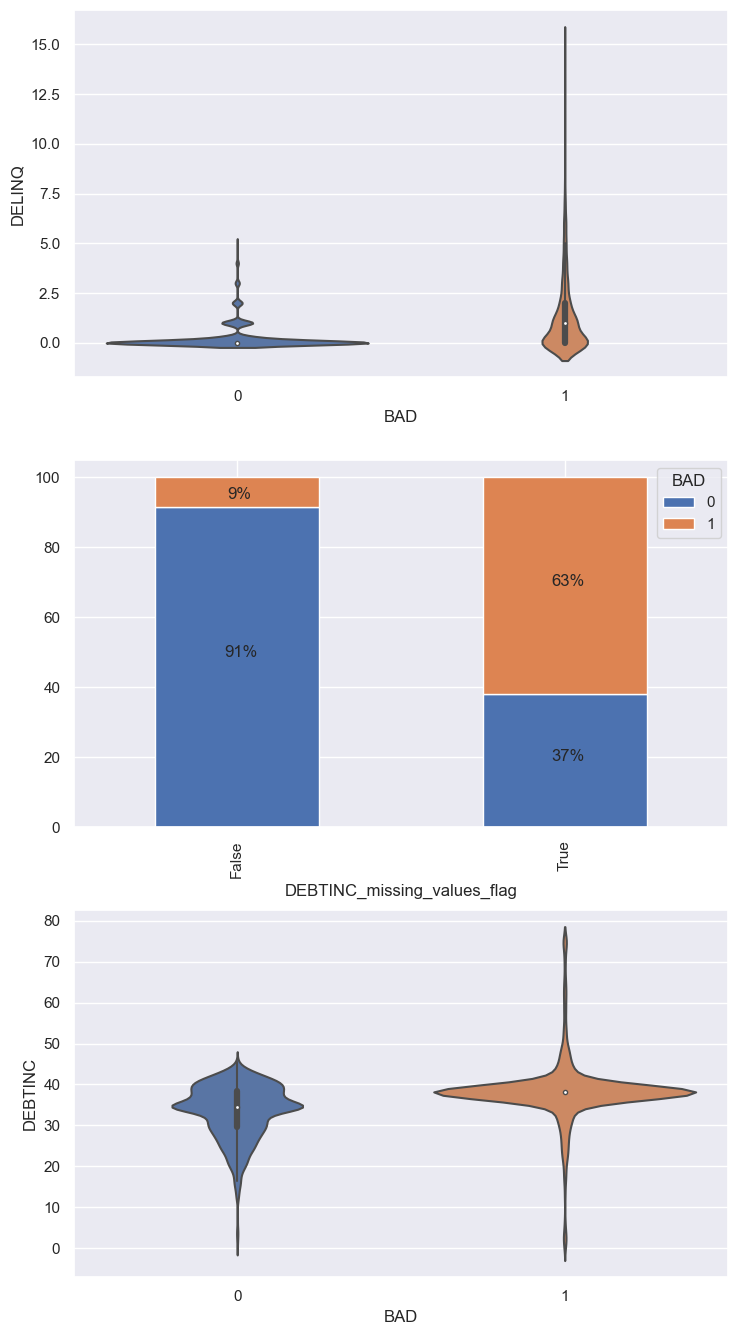

In [20]:
# Details about the three variables having the largest positive impact on predictions
DEBTINC_nanTuple=annotation('DEBTINC_missing_values_flag')
fig, axes=plt.subplots(3,1,figsize=(8,14))
fig.tight_layout(pad=3)
sns.violinplot(x="BAD",y="DELINQ",data=data,ax=axes[0]);
(pd.crosstab(data['DEBTINC_missing_values_flag'],data['BAD'],normalize='index')*100).plot(kind='bar',stacked=True,ax=axes[1]);
axes[1].annotate(DEBTINC_nanTuple[0]+'%',xy=[-.04,DEBTINC_nanTuple[4]+3])
axes[1].annotate(DEBTINC_nanTuple[1]+'%',xy=[-.03,DEBTINC_nanTuple[5]-1.8])
axes[1].annotate(DEBTINC_nanTuple[2]+'%',xy=[.96,DEBTINC_nanTuple[6]])
axes[1].annotate(DEBTINC_nanTuple[3]+'%',xy=[.96,DEBTINC_nanTuple[7]])
sns.violinplot(x="BAD",y="DEBTINC",data=data,ax=axes[2]);

<ul>
    <li>Most of the applicants that do not default tend to have 0 <b>DELINQ</b> and a few of them a small postive value.
        Instead, most of the applicants that to default tend to have some <b>DELINQ</b>. The two distributions are very different in terms of density around the tendency and skew, and this has high positive impact in the predictions.</li>
    <li>9% of the applicants that provided <b>DEBTINC</b> information do default. 63% of the applicants that did not provide <b>DEBTINC</b> information do default. It is plausible that applicants which in reality have a high <b>DEBTINC</b> value (and thus their income is too low to face all their debts) tend to not provide a value.</li>
    <li>The previous insight seems to be confirmed by the last plot, where the distributiion of those who do default  has an higher density around the central value, and this density is located at an higher <b>DEBTINC</b> value. Furthermore, the distribution of defaulters is much more symmetric, while those of not defaulters is left-skewed.</li>
</ul>

Text(0.97, 94.07813620071686, '9%')

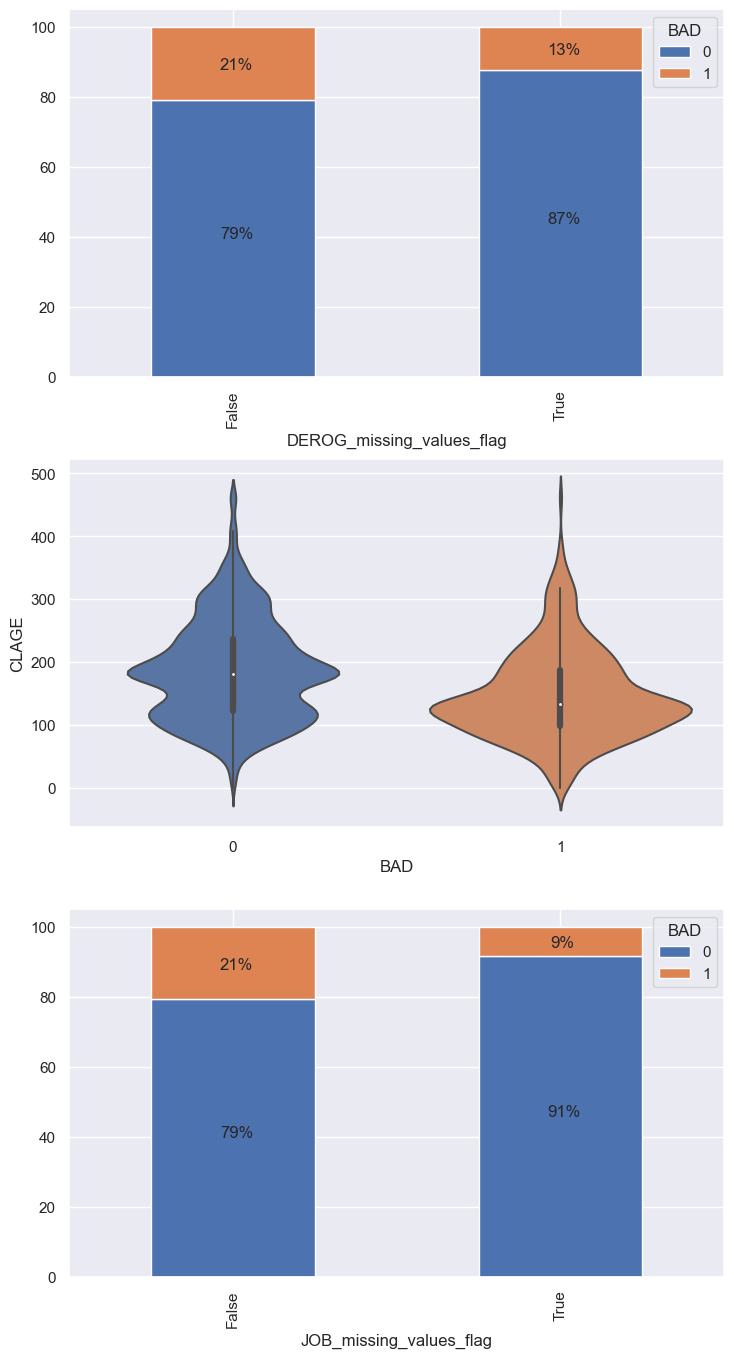

In [21]:
# Details about the three variables having the largest negative impact on predictions
DEROG_nanTuple=annotation('DEROG_missing_values_flag')
JOB_nanTuple=annotation('JOB_missing_values_flag')
fig, axes=plt.subplots(3,1,figsize=(8,14))
fig.tight_layout(pad=3)
(pd.crosstab(data['DEROG_missing_values_flag'],data['BAD'],normalize='index')*100).plot(kind='bar',stacked=True,ax=axes[0]);
axes[0].annotate(DEROG_nanTuple[0]+'%',xy=[-.04,DEROG_nanTuple[4]])
axes[0].annotate(DEROG_nanTuple[1]+'%',xy=[-.04,DEROG_nanTuple[5]-1.6])
axes[0].annotate(DEROG_nanTuple[2]+'%',xy=[.96,DEROG_nanTuple[6]])
axes[0].annotate(DEROG_nanTuple[3]+'%',xy=[.96,DEROG_nanTuple[7]-1.8])
sns.violinplot(x="BAD",y="CLAGE",data=data,ax=axes[1]);
(pd.crosstab(data['JOB_missing_values_flag'],data['BAD'],normalize='index')*100).plot(kind='bar',stacked=True,ax=axes[2]);
axes[2].annotate(JOB_nanTuple[0]+'%',xy=[-.04,JOB_nanTuple[4]])
axes[2].annotate(JOB_nanTuple[1]+'%',xy=[-.04,JOB_nanTuple[5]-1.8])
axes[2].annotate(JOB_nanTuple[2]+'%',xy=[.96,JOB_nanTuple[6]])
axes[2].annotate(JOB_nanTuple[3]+'%',xy=[.97,JOB_nanTuple[7]-1.8])

All three variables that most contributed negatively to the predictions have an opposite behaviour to those of variables with positive contribution:
<ul>
<li>21% of the applicants that provided <b>DEROG</b> information do default. 13% of the applicants that did not provide <b>DEROG</b> information do default.</li>
    <li>The central tendency of no defaulters is located at higher <b>CLAGE</b> value thant that of defaulter.</li>
    <li>21% of the applicants that provided <b>JOB</b> information do default. 9% of the applicants that did not provide <b>DEROG</b> information do default.</li>
</ul>
Moreover, the differences between the two <b>DEFAULT</b> groups are sharper for variables having the positive contribution to the predictions, indeed the absolute value of their coefficients is greater.

In [22]:
# Let's define a function to plot the Precision/Recall curve
def PrecisionRecall_curve(data,model):
    global y_scores
    y_scores = model.predict_proba(data) 
    precisions,recalls,thresholds= precision_recall_curve(y_train, y_scores[:, 1])
    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize = (10, 7))
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0, 1])

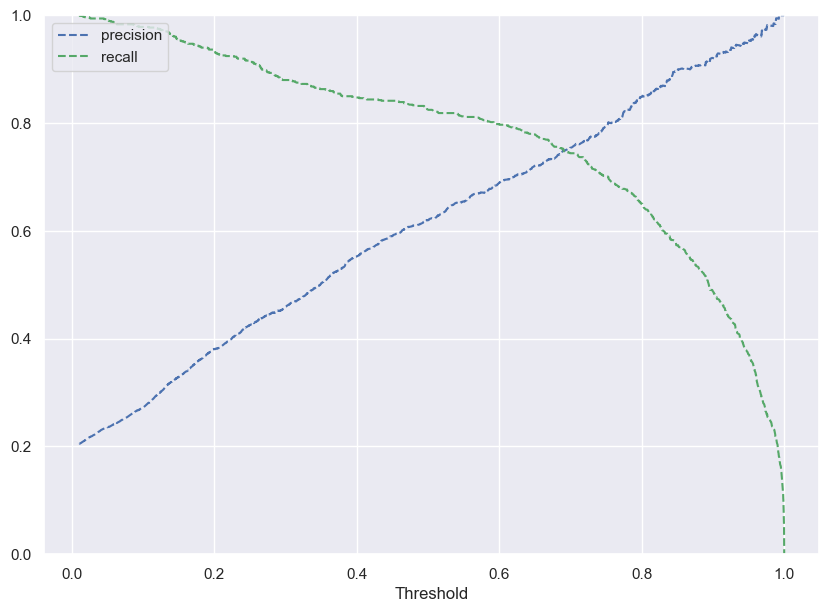

In [23]:
# Plot the Precision/Recall curve for the Logistic Regression model
PrecisionRecall_curve(X_train_scaled__,lg3)

The Logistic Regression model was built with a threshold of 0.5, however it seems that the best balance between 
precision and recall is reached at a threshold of about 0.7. Beyond this threshold, the decay in Recall is very fast.

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3340
           1       0.75      0.75      0.75       832

    accuracy                           0.90      4172
   macro avg       0.84      0.84      0.84      4172
weighted avg       0.90      0.90      0.90      4172



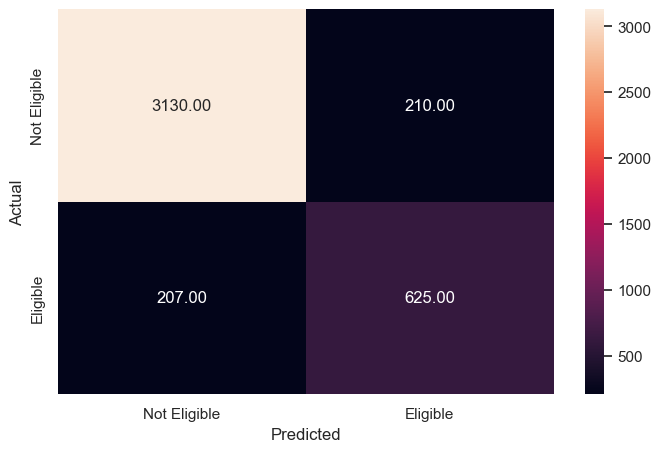

In [24]:
opt_threshold=.69

metrics_score(y_train,y_scores[:,1]>opt_threshold)

<ul>
    <li>The performance of this model has overall decreased since precision improved at a significative cost in terms of Recall, which is not desirable in this case study.</li>
<li>Accuracy has improved as well, however this metric is ignored due to the imbalance in the <b>BAD</b> categories. At the equilibrium, this model is able to provide 75% score on Precision and Recall metrics.</li>
    <li>Since the objective is maximization of Recall, the threshold may be moved below .5 in order to increase it, but this will entail a big cost in terms of Precision loss since below .5 the Precision curve has larger slope than the Recall curve.</li>
    <li>Anyway, if the business deems that the model is too rik-adverse as it cuts off too many applicants, the model can be adapted to some degree by adjusting the threshold in the Precision-Recall curve.</li>
</ul>

**Creating a dictionary storing Accuracy-Recall_Precision on both sets for each candidate model** 

In [25]:
def addModel(model,train,test,dataFrame=None,extra="_"):
    columns=["trainAcc","testAcc","trainRec","testRec","trainPre","testPre"]
    metrics=[accuracy_score(y_train,model.predict(train)),
             accuracy_score(y_test,model.predict(test)),
             recall_score(y_train,model.predict(train)),
             recall_score(y_test,model.predict(test)),
             precision_score(y_train,model.predict(train)),
             precision_score(y_test,model.predict(test))
             ]
    new=pd.DataFrame(data=metrics,index=columns,columns=[type(model).__name__+extra]).T
    if dataFrame is None: return new
    return dataFrame.append(pd.DataFrame(data=metrics,index=columns,columns=[type(model).__name__+extra]).T)

In [26]:
# Adding the Logistic Regression model to candidate model collection
candidateModels=addModel(lg3,X_train_scaled__,X_test_scaled__)

In [27]:
# Free memory not in use
del X_test_scaled_,X_

### **Build a Probit Model** 

In [28]:
# Checking which features are significant in predicting default
probit_model=sm.Probit(y_train,X_train_scaled_).fit()
print(probit_model.summary())

# Free memory not in use
del X_train_scaled_

Optimization terminated successfully.
         Current function value: 0.474360
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4172
Model:                         Probit   Df Residuals:                     4146
Method:                           MLE   Df Model:                           25
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                 0.05053
Time:                        14:40:44   Log-Likelihood:                -1979.0
converged:                       True   LL-Null:                       -2084.3
Covariance Type:            nonrobust   LLR p-value:                 2.715e-31
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
LOAN                           -0.0094      0.026     -0.360      0.719   

From the statistics above, it seems that with the confidence level of 95% the following features are NOT significant: <b>LOAN</b>, <b>VALUE</b>, <b>YOJ</b>, <b>REASON_missing_values_flag</b>, <b>DELINQ_missing_values_flag</b>, <b>CLAGE_missing_values_flag</b>, <b>NINQ_missing_values_flag</b>, <b>CLNO_missing_values_flag </b>, <b>REASON_HomeImp</b>, <b>JOB_Other</b>, <b>JOB_ProfExe</b>, <b>JOB_Sales</b> and <b>JOB_Self</b>

In [29]:
probit_model1Feat=["DEROG","DELINQ","CLAGE","NINQ","CLNO","DEBTINC","MORTDUE_missing_values_flag",
                  "VALUE_missing_values_flag","JOB_missing_values_flag","YOJ_missing_values_flag",
                  "DEROG_missing_values_flag","DEBTINC_missing_values_flag","JOB_Office"]

The dataset will be upsampled in order to balance the number of instances in the two classes using the SMOTE algorithm.

SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE:
<ul>
<li>Works by creating synthetic samples from the minor class (default) instead of creating copies.</li>
<li>Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.</li>
</ul>

In [30]:
# train-test split
X_train, X_test= train_test_split(X,test_size = 0.30, random_state = 1, stratify=Y)

# applying SMOTE algorithm to train data
osAlgorithm = SMOTE(random_state=0)
os_data_X,Y_os=osAlgorithm.fit_resample(X_train, y_train)

# shuffling the oversampled set as all synthetic istances of sample class were appended at the end
os_data_X["BAD"]=Y_os
os_data_X=os_data_X.sample(frac=1,random_state=7)

# separate features and targets
X_os=os_data_X.drop(columns='BAD')
Y_os=os_data_X.BAD
X_all=pd.concat([X_os,X_test])

# standardizing the features of interest
scaler=StandardScaler()
X_all_scaled=pd.DataFrame(scaler.fit_transform(X_all[probit_model1Feat]),columns=[probit_model1Feat]).reindex(X_all.index)

# retrieving the train-test split
X_os_scaled,X_test_sc=X_all_scaled[:len(X_os)],X_all_scaled[len(X_os):]

# adding to the two sets the constant term
X_train_const,X_test_const=sm.add_constant(X_os_scaled),sm.add_constant(X_test_sc)

# free memory not in use
del X_os,X_all,X_os_scaled,X_test_sc

In [31]:
# defining the Probit function
def normsdist(z):
    z = si.norm.cdf(z,0.0,1.0)
    return (z)

In [32]:
# fit the probit model on the dataset with synthetic instances
probit_model1=sm.Probit(Y_os,X_train_const).fit()

# performing the linear combination
for col in probit_model1.params.index:
    X_train_const[col]*=probit_model1.params[col]  
X_train_const["Z"]=np.zeros(len(X_train_const))
for col in X_train_const.columns[:-1]:
    X_train_const["Z"]+=X_train_const[col]
    
# adding a column to train set with probabilities
X_train_const["fi(Z)"]=X_train_const["Z"].map(normsdist)

# converting probabilities to classes
X_train_const["pred"]=X_train_const["fi(Z)"].apply(lambda x:1 if x>.5 else 0)

Optimization terminated successfully.
         Current function value: 0.692382
         Iterations 3


In [33]:
# predicting on test set
for col in probit_model1.params.index:
    X_test_const[col]*=probit_model1.params[col]  
X_test_const["Z"]=np.zeros(len(X_test_const))
for col in X_test_const.columns[:-1]:
    X_test_const["Z"]+=X_test_const[col]
X_test_const["fi(Z)"]=X_test_const["Z"].map(normsdist)
X_test_const["pred"]=X_test_const["fi(Z)"].apply(lambda x:1 if x>.5 else 0)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.52      0.40      0.45      3340
           1       0.51      0.64      0.57      3340

    accuracy                           0.52      6680
   macro avg       0.52      0.52      0.51      6680
weighted avg       0.52      0.52      0.51      6680



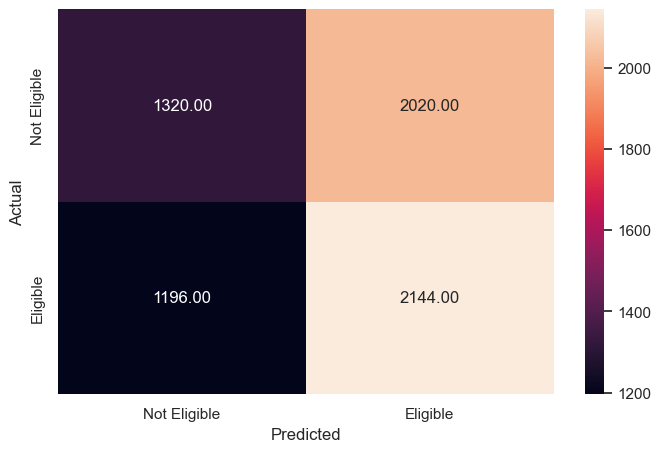

In [34]:
# Checking the performance on the train dataset
metrics_score(Y_os,X_train_const.pred)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.81      0.39      0.53      1431
           1       0.21      0.63      0.31       357

    accuracy                           0.44      1788
   macro avg       0.51      0.51      0.42      1788
weighted avg       0.69      0.44      0.49      1788



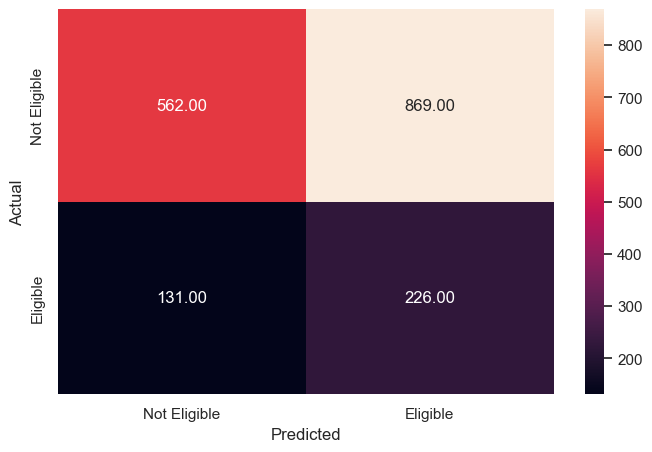

In [35]:
#checking the performance on the test dataset
metrics_score(y_test,X_test_const.pred)

<ul>
<li>The probit model is overfitting the training set as the Precision score is 30% higher than on test set.</li>
<li>The performance of probit model is significantly worse than those of logistic regression on all metrics, in particular on test set the Precision score is 41% lower.</li>
</ul>

In [36]:
columns=["trainAcc","testAcc","trainRec","testRec","trainPre","testPre"]
metrics_=[accuracy_score(Y_os,X_train_const.pred),
             accuracy_score(y_test,X_test_const.pred),
             recall_score(Y_os,X_train_const.pred),
             recall_score(y_test,X_test_const.pred),
             precision_score(Y_os,X_train_const.pred),
             precision_score(y_test,X_test_const.pred)
             ]
candidateModels=candidateModels.append(pd.DataFrame(data=metrics_,index=columns,columns=["Probit_"]).T)

In [37]:
# free memory not in use
del Y_os,X_train_const,X_test_const

### **Build a Decision Tree Model**

In [38]:
data_=pd.read_csv('dataWithOutliers.csv')

#### Separating the target variable y and independent variable x

In [39]:
# Drop dependent variable from dataframe and create the X(independent variable) matrix
X=data_.drop(columns='BAD')

# Create dummy variables for the categorical variables - Hint: use the get_dummies() function
X=pd.get_dummies(X,drop_first=True)

# Create y(dependent varibale)
Y=data_.BAD

<ul>
<li>Tree-based model do not need data preprocessing since they are built by splitting a single feature at each level, therefore difference in the scale of values across different features is not relevant. </li>
 <li>This class of models is not sensitive to outliers or noisy data. Since these values never cause much reduction in the cost function, they are never involved in the split.</li>
</ul>

#### Split the data

In [40]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1, stratify=Y)

In [41]:
# Defining Decision tree model with class weights class_weight={0: 0.2, 1: 0.8}
d_tree = DecisionTreeClassifier(class_weight={0:y_train.value_counts(normalize=1)[1],1:y_train.value_counts(normalize=1)[0]},random_state=7)

In [42]:
# Fitting Decision tree model
d_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.19942473633748803,
                                     1: 0.800575263662512},
                       random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



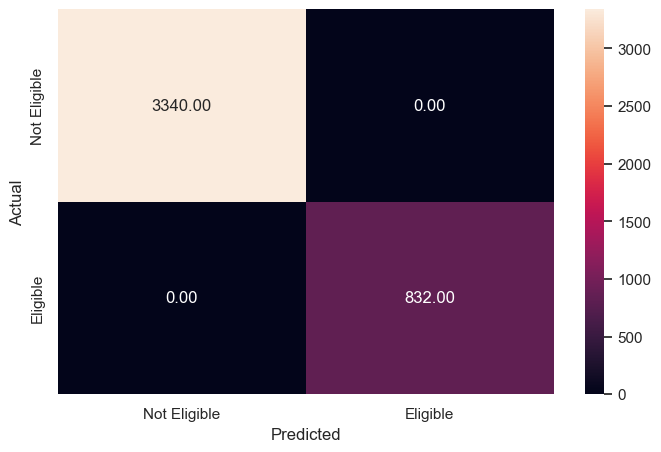

In [43]:
# Checking performance on the training data
y_pred_train2=d_tree.predict(X_train)
metrics_score(y_train,y_pred_train2)

The performance of the Decision Tree is perfect on the training set, for all metrics. This outcome is not surprising, since this model without any restriction most of the times tends to overfit the training data.

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1431
           1       0.88      0.85      0.86       357

    accuracy                           0.95      1788
   macro avg       0.92      0.91      0.91      1788
weighted avg       0.95      0.95      0.95      1788



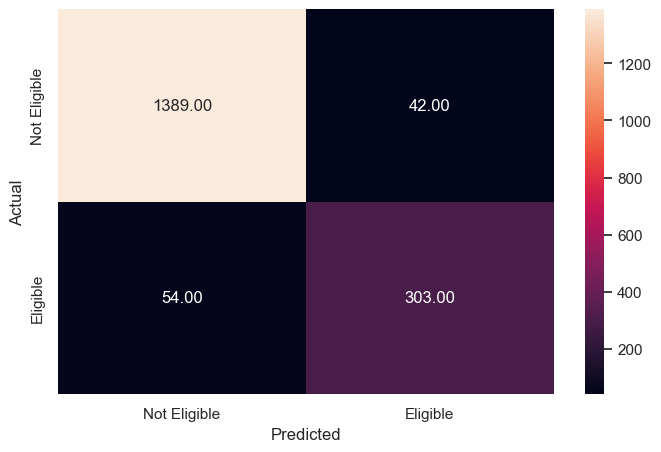

In [44]:
# Checking performance on the testing data
y_pred_test2=d_tree.predict(X_test)
metrics_score(y_test,y_pred_test2)

The Decision Tree worked very well on the training data, but worse on the test data. The Precision and Recall here are 88% and 85% respectively, compared to 100% in the train set.<br>
In order to reduce this strong overfitting, let's try to grow a better Decision Tree using <b>Grid Search Cross Validation</b>.

In [45]:
# Adding the Decision Tree model to candidate model collection
candidateModels=addModel(d_tree,X_train,X_test,candidateModels)

### **Decision Tree - Hyperparameter Tuning**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**min_samples_split**

The minimum number of samples required to split an internal node.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

**max_features**

The number of features to consider when looking for the best split.

**max_depth**

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


**class_weight**

Weights associated with classes.

#### Using RandomizedSearchCV for Hyperparameter tuning on the model trying random combinations

In [46]:
"""
d_tree_tuned = DecisionTreeClassifier(random_state = 7)
distributions={"criterion":['gini','entropy'],
              "min_samples_split":range(1,60),
              "min_samples_leaf": range(5,100),
              "max_features":['auto', 'sqrt', 'log2', None],
              "max_depth":range(5,100),
              "class_weight":[{0:.2,1:.8},"balanced"]
              }

scorer = metrics.make_scorer(recall_score, pos_label = 1)

clf = RandomizedSearchCV(d_tree_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)
search = clf.fit(X_train,y_train)
search.best_params_
"""

'\nd_tree_tuned = DecisionTreeClassifier(random_state = 7)\ndistributions={"criterion":[\'gini\',\'entropy\'],\n              "min_samples_split":range(1,60),\n              "min_samples_leaf": range(5,100),\n              "max_features":[\'auto\', \'sqrt\', \'log2\', None],\n              "max_depth":range(5,100),\n              "class_weight":[{0:.2,1:.8},"balanced"]\n              }\n\nscorer = metrics.make_scorer(recall_score, pos_label = 1)\n\nclf = RandomizedSearchCV(d_tree_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)\nsearch = clf.fit(X_train,y_train)\nsearch.best_params_\n'

#### Using GridSearchCV for Hyperparameter tuning on the model around the values found with RandomizedSearchCV

In [47]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals 
d_tree_tuned = DecisionTreeClassifier(criterion="entropy",class_weight="balanced",random_state=7)


# Grid of parameters to choose from
parameters = {'min_samples_split':range(1,5),
              'min_samples_leaf': np.arange(36,40),
              'max_depth': np.arange(10,15)               
             }


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search
grid_obj = GridSearchCV(d_tree_tuned, parameters, scoring = scorer, cv = 5)


# Fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train, y_train)


# Set the clf to the best combination of parameters
d_tree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=38, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3340
           1       0.75      0.90      0.82       832

    accuracy                           0.92      4172
   macro avg       0.86      0.91      0.88      4172
weighted avg       0.93      0.92      0.92      4172



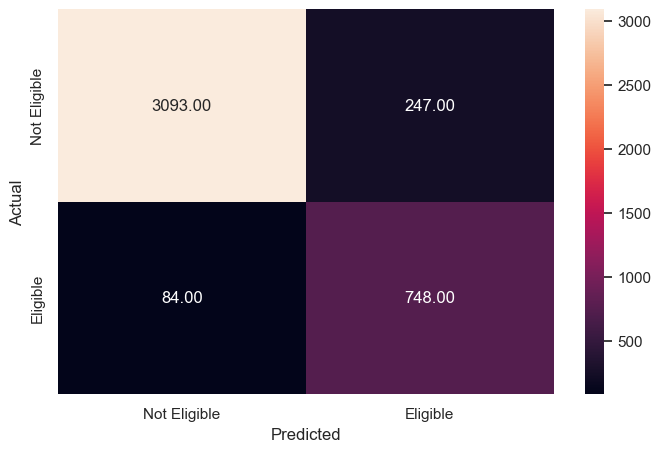

In [48]:
# Checking performance on the training data based on the tuned model
y_pred_train3 = d_tree_tuned.predict(X_train)

metrics_score(y_train,y_pred_train3)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1431
           1       0.71      0.82      0.76       357

    accuracy                           0.90      1788
   macro avg       0.83      0.87      0.85      1788
weighted avg       0.90      0.90      0.90      1788



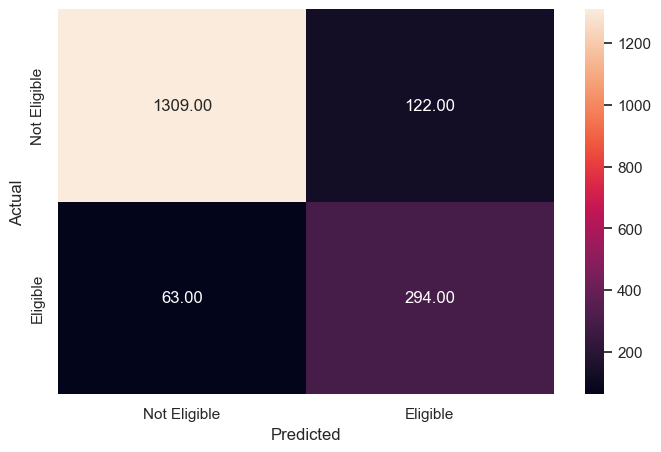

In [49]:
# Checking performance on the testing data based on the tuned model
y_pred_test3 = d_tree_tuned.predict(X_test)

metrics_score(y_test,y_pred_test3)

<ul>
    <li>The tuned Decision Tree is performing worse than the one with default parameters on both sets and both metrics, on test set we have precision (71%-88%) and recall (82%-85%). This is normal, since as we have regularized the model we are trading less predictive power with higher generalization capability. </li>
    <li>However, overfitting is not entirely solved since there are still gaps between train and test on both precision (75%-71%) and recall (90%-82%).</li>
    <li>The tuned Decision Tree is more powerful than the Logistic Regression model since on the test set at a similar Recall it has higher Precision (71%-62%).</li>
    <li>However, the tuned Decision tree is a more compex model, and in this case is overfitting the training set (while the LogisticRegressin was not).</li>
    <li>Nonethless, this is still a better model than the unconstrained Decision Tree which was overfitting data badly.</li>
    <li>In order to decrease the high variance typical of a single Decision Tree, Ensemble Methods can be used.</li>
</ul>

#### Plotting the Decision Tree

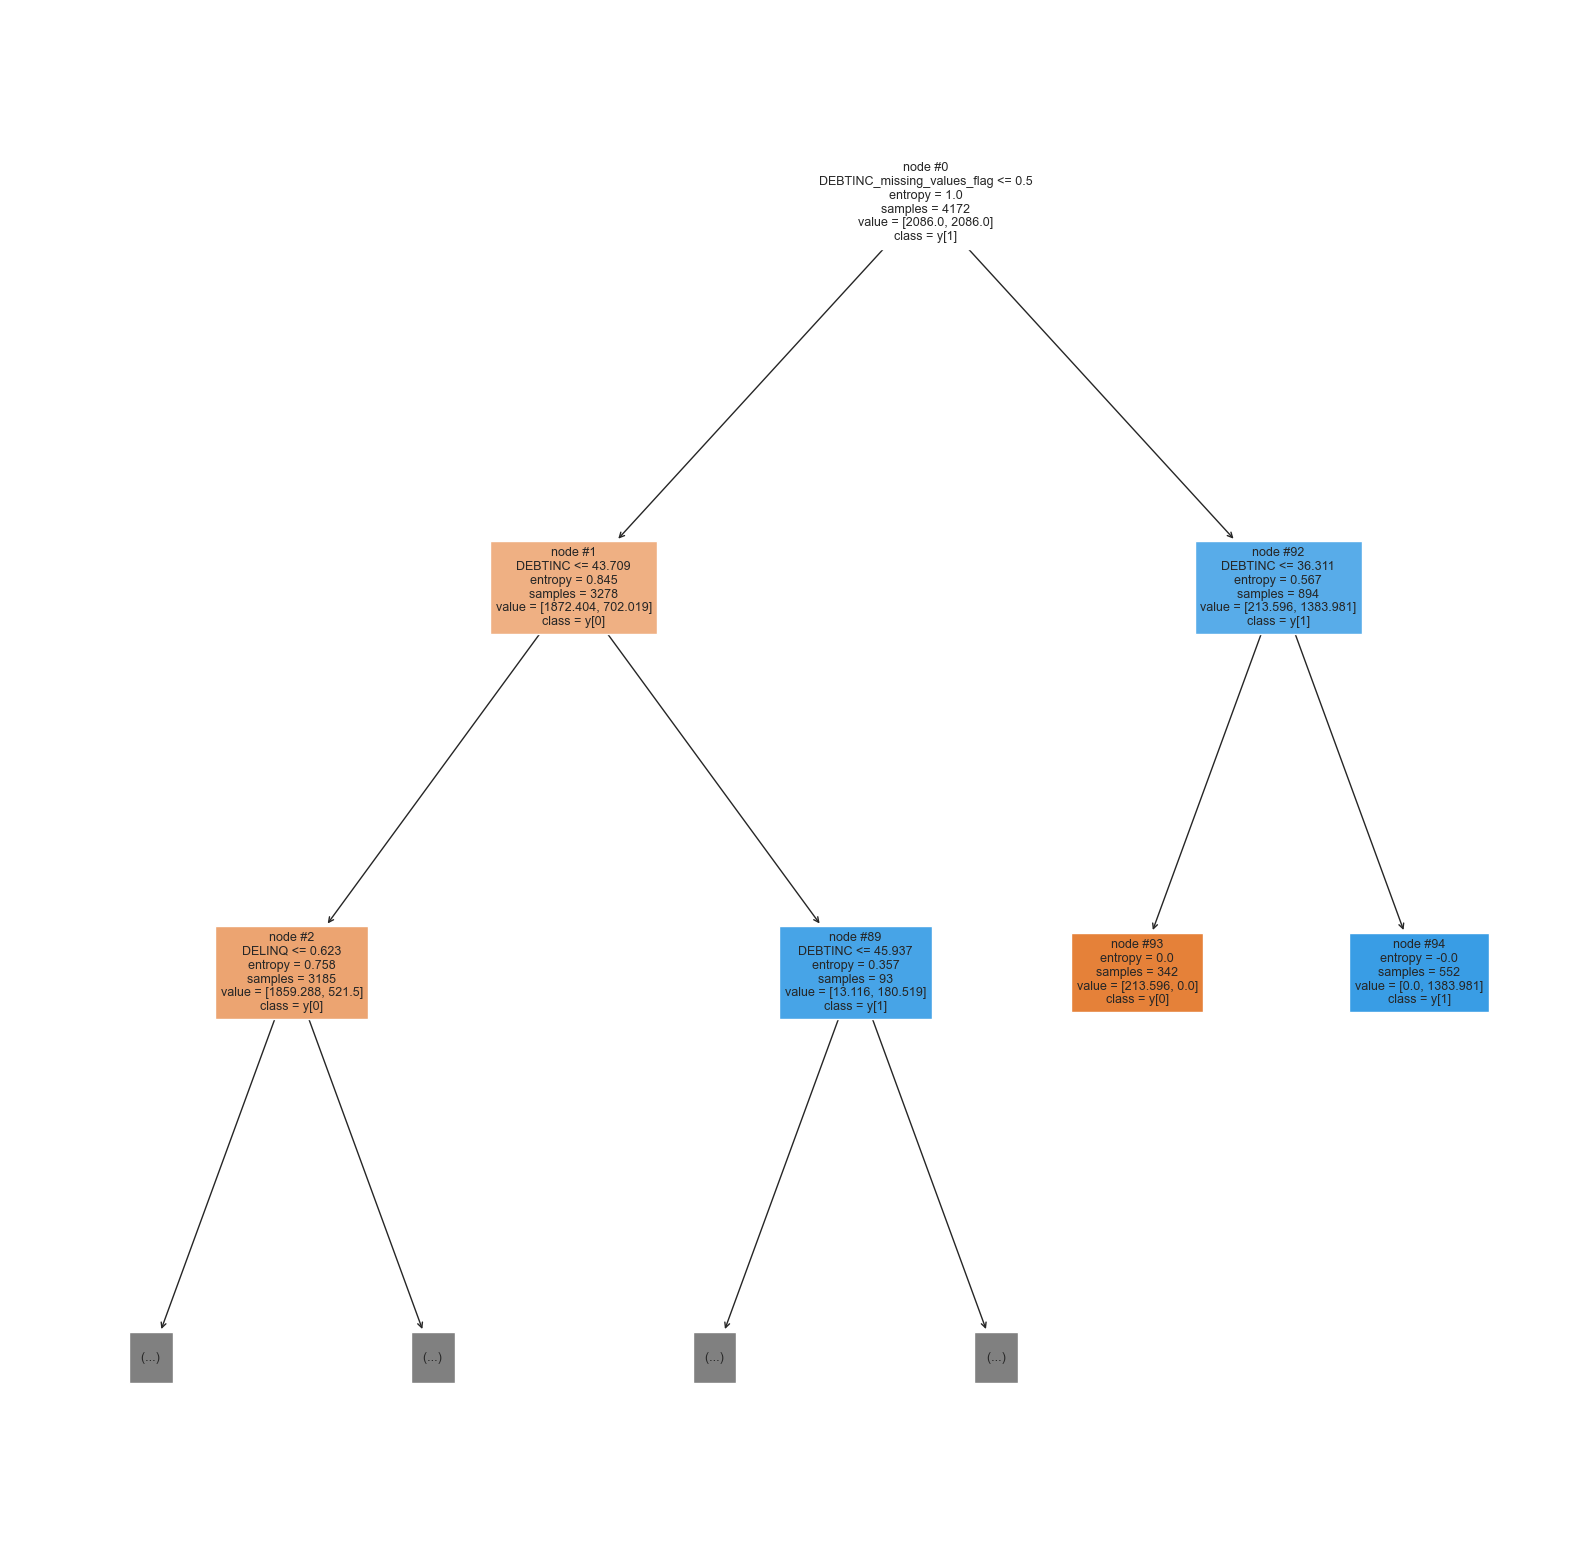

In [50]:
# Plot the decision  tree and analyze it to build the decision rule
features = list(X.columns)

plt.figure(figsize = (20, 20))

tree.plot_tree(d_tree_tuned, feature_names = features, filled = True, fontsize = 9, node_ids = True, class_names = True,max_depth=2)

plt.show()

<b>Note</b>: Blue leaves represent the defaulting applicants, i.e., <b>y[1]</b>, while the orange leaves represent the not defaulting applicants, i.e., y[0]. Also, the more the number of observations in a leaf, the more intense its color gets.<br>
<b>Observations:</b>
<ul>
    <li>In the segment of the applicants that provided a value for <b>DEBTINC</b>:</li> 
        <ul>
            <li>those who have low <b>DEBTINC</b> are likely to not default.</li>
            <li>those who have high <b>DEBTINC</b> are with a good confidence likely to default.</li>
        </ul>
    The decision rule for this branch goes on till max_depth=12.
        <li>In the segment of the applicants that did not provide a value for <b>DEBTINC</b>:</li>
        <ul>
            <li>those who have low <b>DEBTINC</b> are with a good confidence likely to not default.</li>
            <li>thosw who have high <b>DEBTINC</b> are with good confidence likely to default.</li>
        </ul>
    
</ul>

#### Plot the Feature importance of the tuned Decision Tree

Text(0.5, 0, 'Relative Importance')

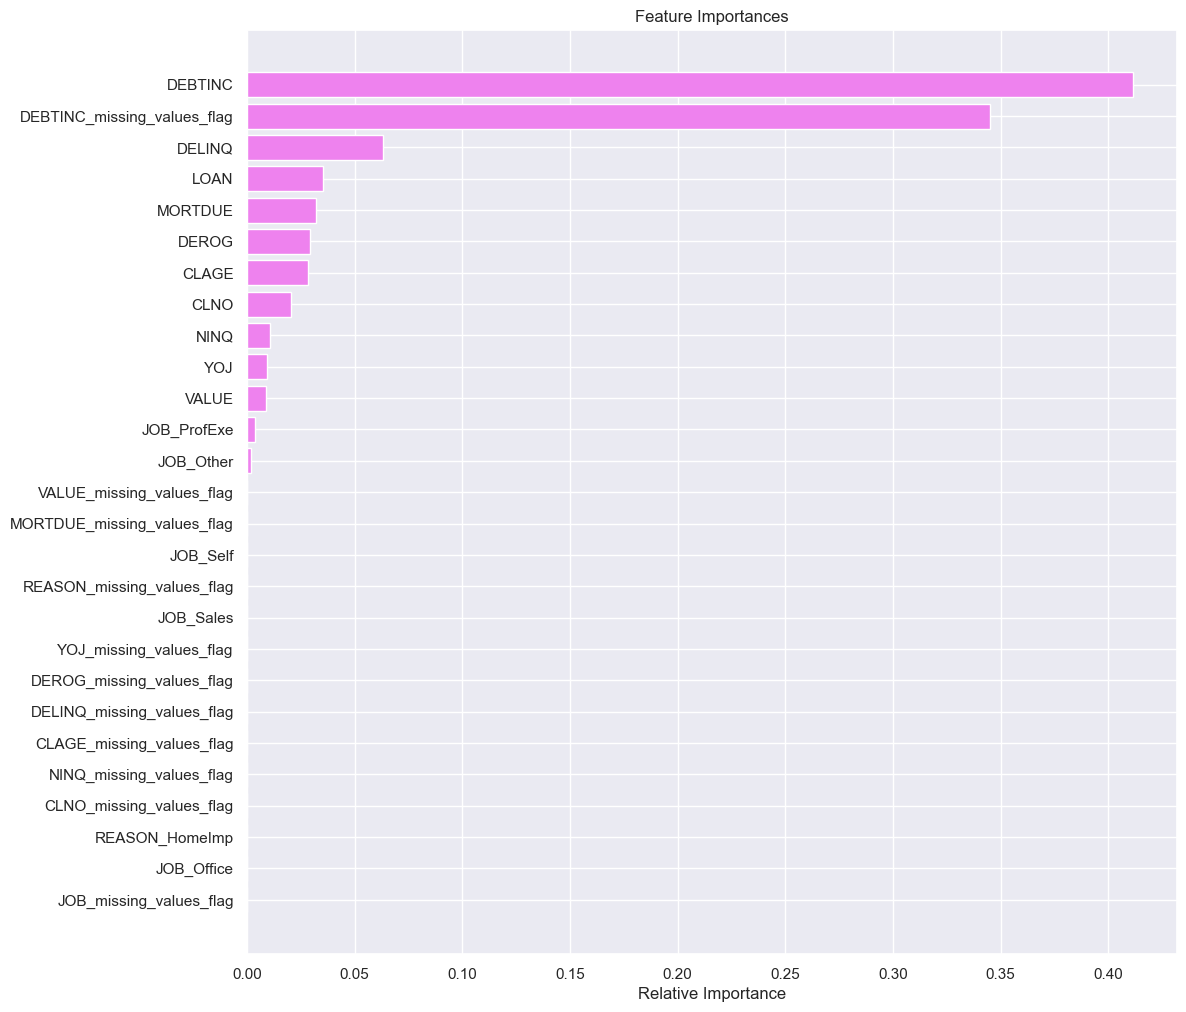

In [51]:
# importance of features in the tree building ( The importance of a feature is computed as the 
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )
importances = d_tree_tuned.feature_importances_

indices = np.argsort(importances)

feature_names = list(X.columns)

plt.figure(figsize = (12, 12))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

<ul>
<li><b>DEBTINC and DEBTINC_missing_values_flag are the most important features, followed in decreasing order by DELINQ, LOAN, MORTDUE and CLAGE.</b></li>
<li><b>CLNO, DEROG, DEROG_missing_values_flag, NINQ, YOJ, VALUE, JOB_ProfExe and JOB_Other have progressively fewer importance.</b>
    <li><b>Features without any pink horizontal bar associated are not considered by the model.</b></li>
</ul>

In [52]:
# Adding the tuned Decison Tree model to candidate model collection
candidateModels=addModel(d_tree_tuned,X_train,X_test,candidateModels,extra="_tuned")

### **Building a Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction. 

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

In [53]:
# Defining Random forest classifier
rf_estimator = RandomForestClassifier(random_state=7)

# Fitting Random forest model
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



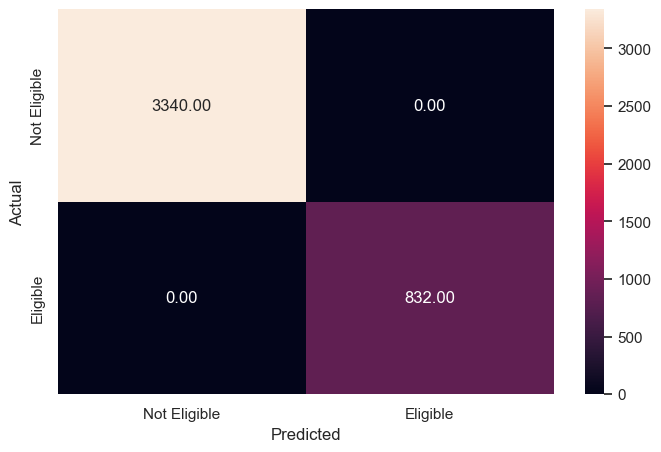

In [54]:
#Checking performance on the training data
y_pred_train4 = rf_estimator.predict(X_train)

metrics_score(y_train,y_pred_train4)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1431
           1       1.00      0.82      0.90       357

    accuracy                           0.96      1788
   macro avg       0.98      0.91      0.94      1788
weighted avg       0.97      0.96      0.96      1788



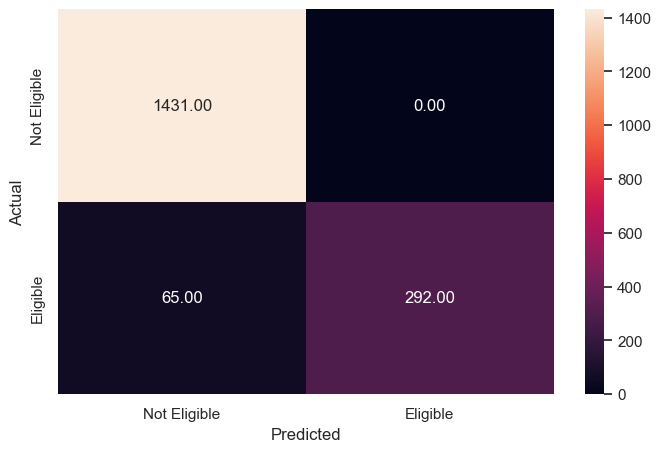

In [55]:
# Checking performance on the test data
y_pred_test4 = rf_estimator.predict(X_test)

metrics_score(y_test,y_pred_test4)

<ul>
<li>The Random Forest worked very well on the training data, but worse on the test data. The recall here is 82%, compared to 100% in the training set. This is overfitting.</li>
<li>Precision is surprisingly perfect on both sets</li>
<li>This model has been run with default parameters, thus is not optimized for the metric of main interest. In our case, the main purpose is maximization of Recall, and the scores obtained (Precision 100% and Recall 82%) are not well suited at all.</li>
<li>Precision/Recall trade-off can be managed by finding a proper threshold through the Precsion-Recall curve. However, a better solution is trying before with hyperparameter tuning.</li>
</ul>

In [56]:
# Adding the Random Forest model to candidate model collection
candidateModels=addModel(rf_estimator,X_train,X_test,candidateModels)

### **Build a Random Forest model with Class Weights**

In [57]:
# Defining Random forest classifier with class weights
rf_estimator_w= RandomForestClassifier(class_weight={0:y_train.value_counts(normalize=1)[1],1:y_train.value_counts(normalize=1)[0]},random_state=7)

# Fitting Random forest model
rf_estimator_w.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.19942473633748803,
                                     1: 0.800575263662512},
                       random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



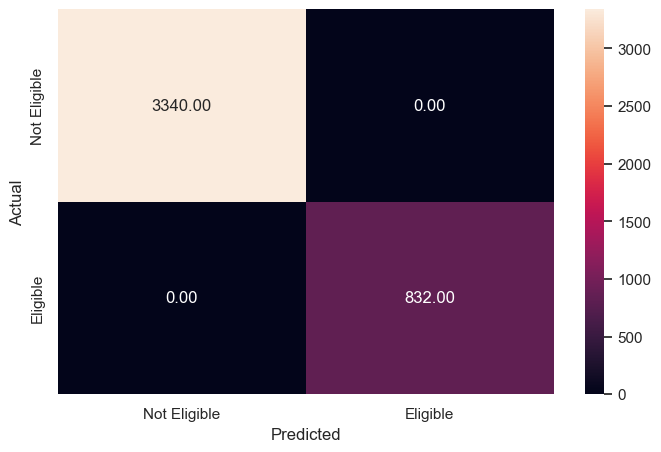

In [58]:
# Checking performance on the train data
y_pred_train5 = rf_estimator_w.predict(X_train)

metrics_score(y_train,y_pred_train5)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1431
           1       1.00      0.79      0.88       357

    accuracy                           0.96      1788
   macro avg       0.98      0.89      0.93      1788
weighted avg       0.96      0.96      0.96      1788



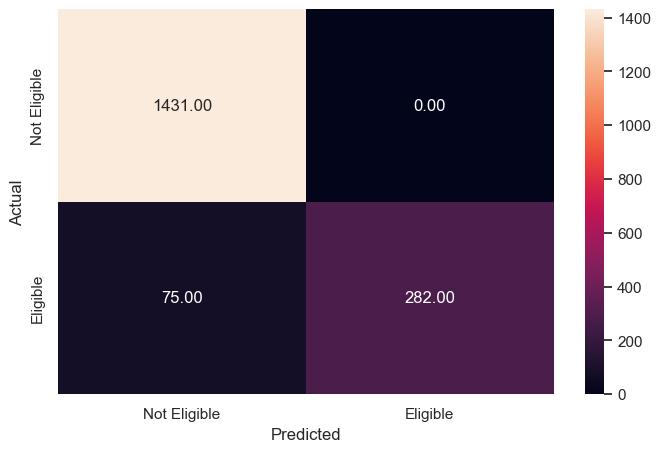

In [59]:
# Checking performance on the test data
y_pred_test5 = rf_estimator_w.predict(X_test)

metrics_score(y_test,y_pred_test5)

<ul>
    <li>The gap between train and test sets on recall 21%, therefore there is overfitting.</li>
    <li>In this case, providing class decreased the performance on test set as Recall is lower.</li>
    <li>Recall is probably not maximized. Once again, cross validation techniques are needed in order to find optimal hyperparameters</li>.
</ul>

In [60]:
# Adding the Random Forest with weights model to candidate model collection
candidateModels=addModel(rf_estimator_w,X_train,X_test,candidateModels,extra="_w")

### **Tuning the Random Forest**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.


The hyperparameters are the same of a Decision Tree, plus

**n_estimators**

The number of trees in the forest.

#### Using RandomizedSearchCV for Hyperparameter tuning on the model trying random combinations

In [61]:
"""
rf_estimator_tuned = RandomForestClassifier(random_state=7)
distributions={"n_estimators": range(10,500),
              "criterion":['gini','entropy'],
              "min_samples_split":range(1,30),
              "min_samples_leaf": range(5,100),
              "max_features":['auto', 'sqrt', 'log2', None],
              "max_depth":range(5,100),
              "class_weight":[{0:.2,1:.8},"balanced"]
              }

scorer = metrics.make_scorer(recall_score, pos_label = 1)

clf = RandomizedSearchCV(rf_estimator_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)
search = clf.fit(X_train,y_train)
search.best_params_
"""

'\nrf_estimator_tuned = RandomForestClassifier(random_state=7)\ndistributions={"n_estimators": range(10,500),\n              "criterion":[\'gini\',\'entropy\'],\n              "min_samples_split":range(1,30),\n              "min_samples_leaf": range(5,100),\n              "max_features":[\'auto\', \'sqrt\', \'log2\', None],\n              "max_depth":range(5,100),\n              "class_weight":[{0:.2,1:.8},"balanced"]\n              }\n\nscorer = metrics.make_scorer(recall_score, pos_label = 1)\n\nclf = RandomizedSearchCV(rf_estimator_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)\nsearch = clf.fit(X_train,y_train)\nsearch.best_params_\n'

#### Using GridSearchCV for Hyperparameter tuning on the model around the values found with RandomizedSearchCV

In [62]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals 
rf_estimator_tuned = RandomForestClassifier(class_weight={0: 0.2, 1: 0.8},
                                            criterion = "gini",
                                            random_state=7,
                                            min_samples_split=2,
                                            n_jobs=-1
                                            )

# Grid of parameters to choose from
parameters = {'n_estimators':[428,430,432],
              "min_samples_leaf":[8,10,12],
              "max_depth":[15,16,17]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = scorer, cv = 10)


#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train, y_train)


# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_


# Fit the best algorithm to the data. 
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=16,
                       min_samples_leaf=10, n_estimators=430, n_jobs=-1,
                       random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3340
           1       0.98      0.91      0.94       832

    accuracy                           0.98      4172
   macro avg       0.98      0.95      0.96      4172
weighted avg       0.98      0.98      0.98      4172



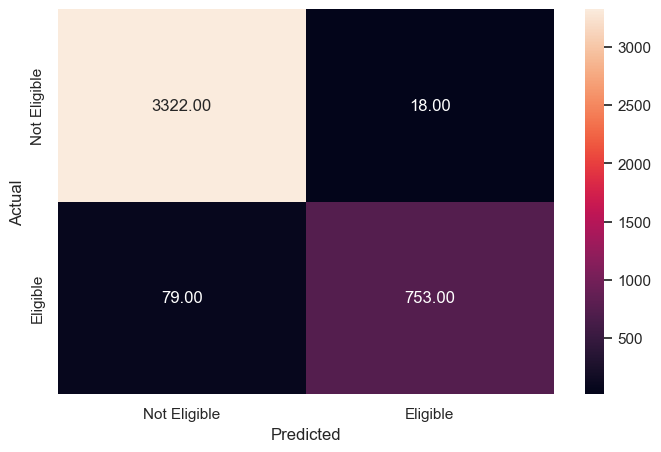

In [63]:
# Checking performance on the training data
y_pred_train6 = rf_estimator_tuned.predict(X_train)

metrics_score(y_train, y_pred_train6)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1431
           1       0.96      0.81      0.88       357

    accuracy                           0.96      1788
   macro avg       0.96      0.90      0.93      1788
weighted avg       0.96      0.96      0.95      1788



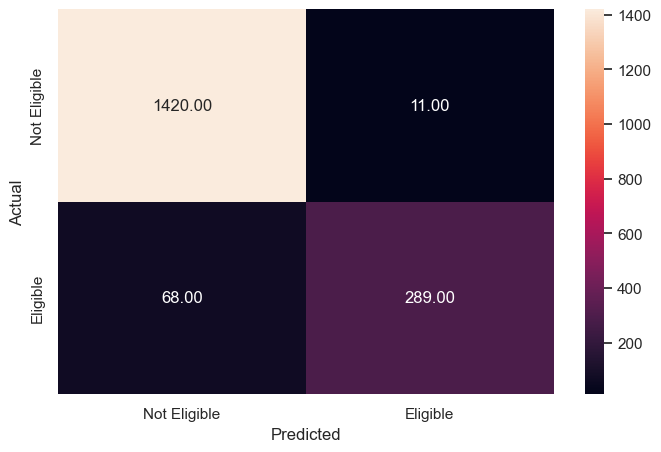

In [64]:
# Checking performace on test dataset
y_pred_test6 = rf_estimator_tuned.predict(X_test)

metrics_score(y_test,y_pred_test6)

<ul>
    <li>This model is still overfitting the training data: the Recall scores on train and test data are 91%-81% respectively.</li>
</ul>

#### Plot the Feature importance of the tuned Random Forest

Text(0.5, 0, 'Relative Importance')

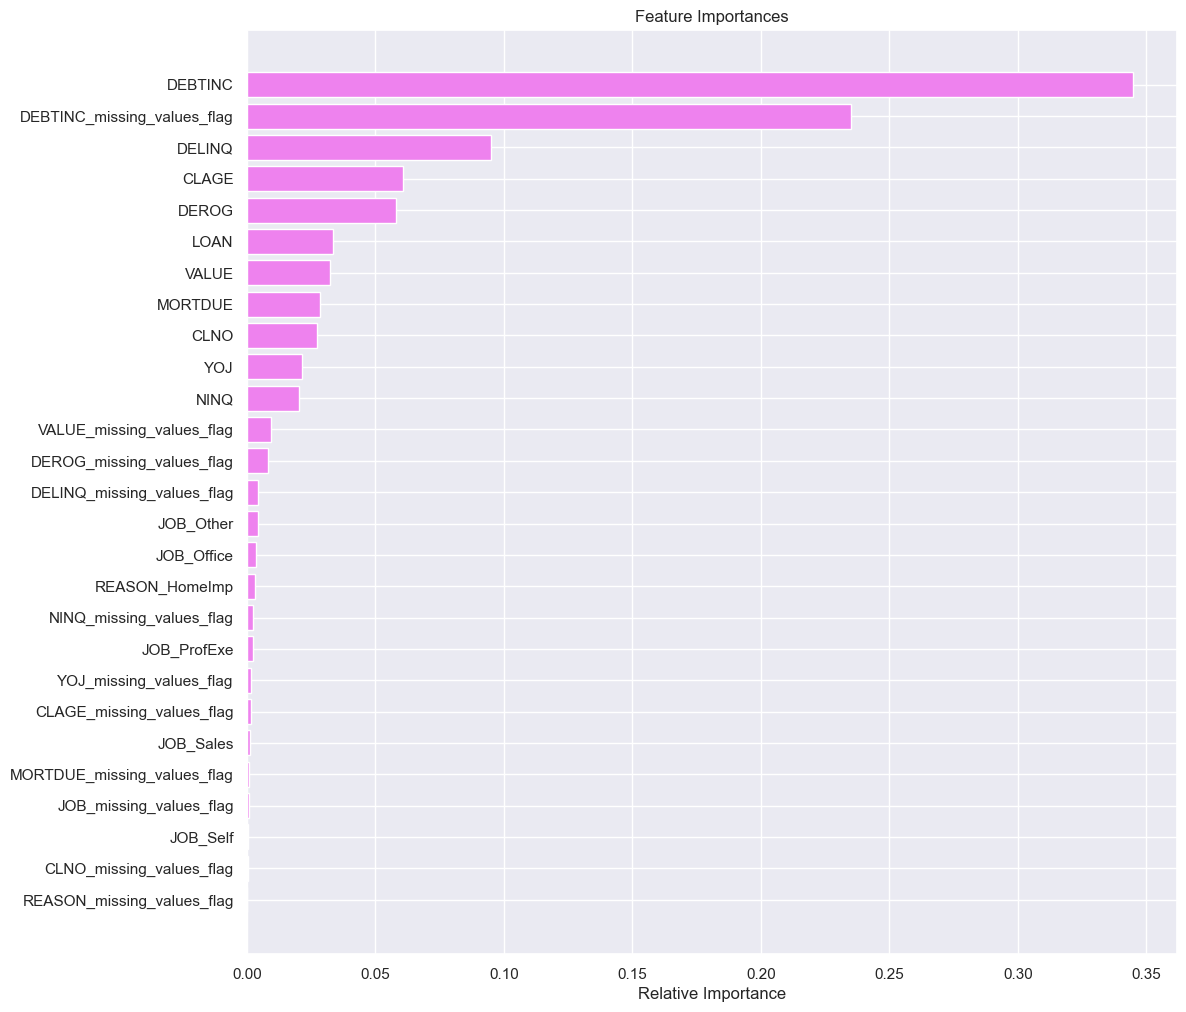

In [65]:
# importance of features in the tree building ( The importance of a feature is computed as the 
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )
importances = rf_estimator_tuned.feature_importances_

indices = np.argsort(importances)

feature_names = list(X.columns)

plt.figure(figsize = (12, 12))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

<ul>
<li><b>DEBTINC and DEBTINC_missing_values_flag are the most important features, followed in decreasing order by DELINQ, CLAGE, DEROG, LOAN, VALUE, MORTDUE, CLNO, YOJ and NINQ.</b></li>
<li><b>VALUE_missing_values_flag, DEROG_missing_values-flag, DELINQ_missing_values_flag ... till JOB_missing_values_flag have progressively fewer importance.</b>
    <li><b>JOB_Self, CLNO_missing_values_flag and REASON_missing_values_flag are not considered by the model.</b></li>
</ul>

In [66]:
# Adding the tuned Random Forest model to candidate model collection
candidateModels=addModel(rf_estimator_tuned,X_train,X_test,candidateModels,extra="_tuned")

### **Building a Linear Discriminant Analysis Model**

In [67]:
lda=LinearDiscriminantAnalysis()
lda.fit(X_train_scaled,y_train)

LinearDiscriminantAnalysis()

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3340
           1       0.79      0.69      0.73       832

    accuracy                           0.90      4172
   macro avg       0.86      0.82      0.84      4172
weighted avg       0.90      0.90      0.90      4172



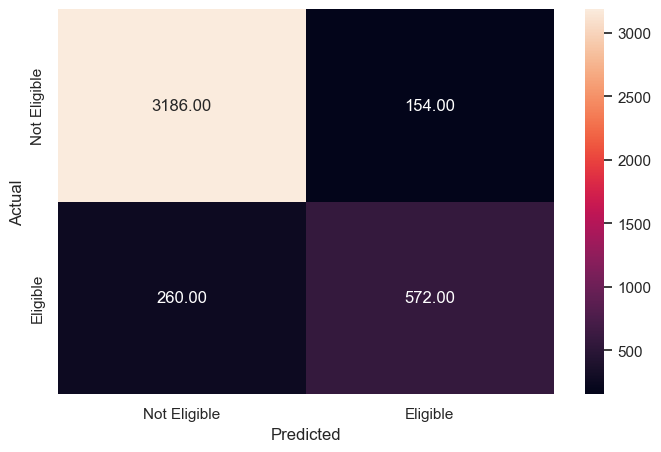

In [68]:
# Checking performance on the training data
y_pred_train7 = lda.predict(X_train_scaled)

metrics_score(y_train, y_pred_train7)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1431
           1       0.79      0.66      0.72       357

    accuracy                           0.90      1788
   macro avg       0.85      0.81      0.83      1788
weighted avg       0.89      0.90      0.89      1788



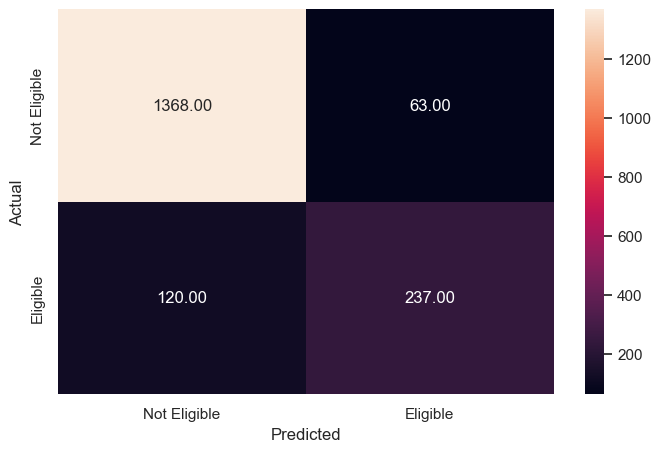

In [69]:
# Checking performance on the test
y_pred_test7 = lda.predict(X_test_scaled)

metrics_score(y_test, y_pred_test7)

<ul>
    <li>Metrics are similar on both datasets, there is not overfitting.</li>
    <li>Precision is higher than Recall on both train (79%-69%) and test (79%-66%) sets.</li>
    <li>This model cares more of Precision than of Recall, which is not desirable.</li>    
</ul>

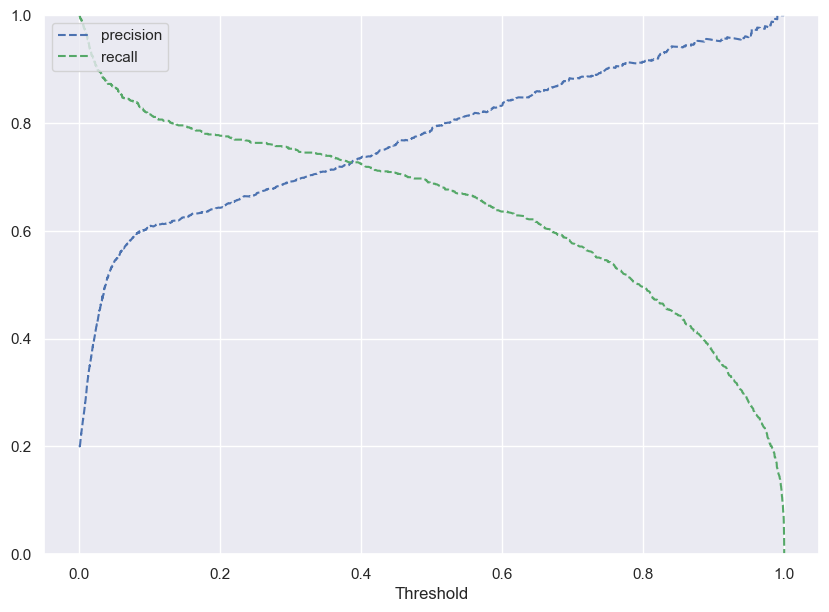

In [70]:
# Plot the Precision/Recall curve for the LDA model
PrecisionRecall_curve(X_train_scaled,lda)

The Linear Discriminant Analysis model was built with a threshold of 0.5, however it seems that the best balance between 
precision and recall is reached at a threshold of about 0.4.

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3340
           1       0.73      0.73      0.73       832

    accuracy                           0.89      4172
   macro avg       0.83      0.83      0.83      4172
weighted avg       0.89      0.89      0.89      4172



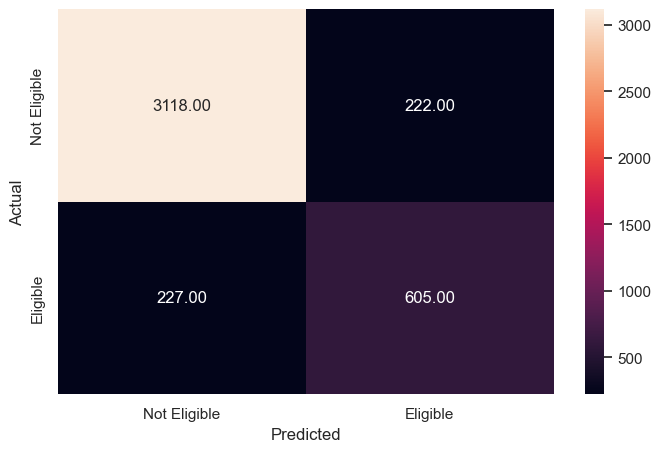

In [71]:
opt_threshold=.39

metrics_score(y_train,y_scores[:,1]>opt_threshold)

At the equiibrium, LDA provides 73% precision and recall while Logistic Regression returned 75%. The latter model is overall modeling data slightly better, it has better interpretability of coefficent through odds ratio and it has more sophisticated feature selection techniques available.

In [72]:
# Adding the LDA model to candidate model collection
candidateModels=addModel(lda,X_train_scaled,X_test_scaled,candidateModels)

### **Building a Quadratic Discriminant Analysis Model**

In [73]:
qda=QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled,y_train)

QuadraticDiscriminantAnalysis()

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3340
           1       0.67      0.65      0.66       832

    accuracy                           0.87      4172
   macro avg       0.79      0.78      0.79      4172
weighted avg       0.86      0.87      0.87      4172



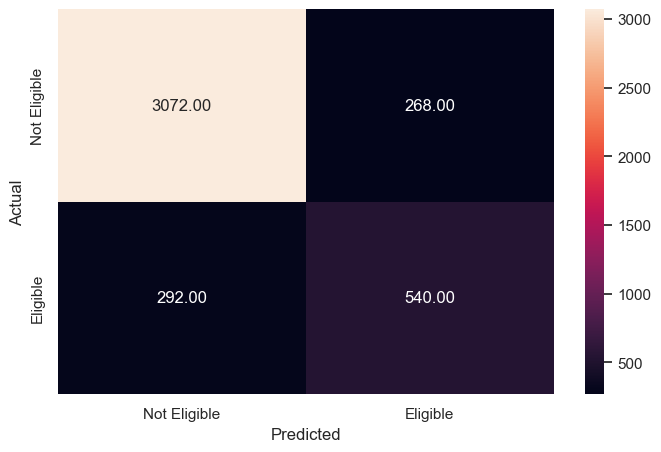

In [74]:
# Checking performance on the training data
y_pred_train8 = qda.predict(X_train_scaled)

metrics_score(y_train, y_pred_train8)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1431
           1       0.72      0.59      0.65       357

    accuracy                           0.87      1788
   macro avg       0.81      0.77      0.79      1788
weighted avg       0.87      0.87      0.87      1788



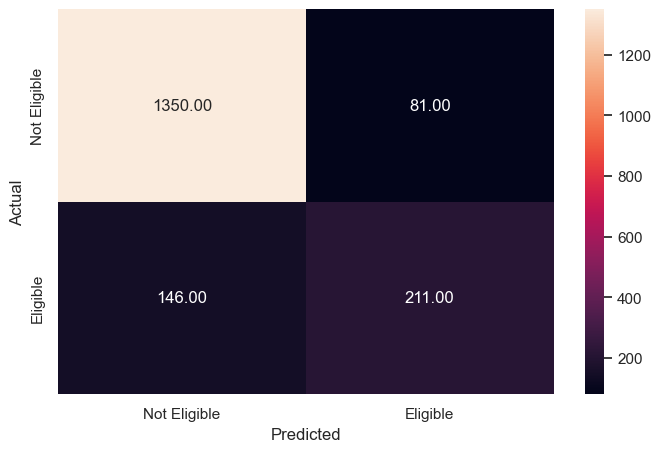

In [75]:
# Checking performance on the test
y_pred_test8 = qda.predict(X_test_scaled)

metrics_score(y_test, y_pred_test8)

<ul>
<li>Metrics are similar on both datasets, there is not strong overfitting.</li>
<li>QDA performs worse than LDA on both precision (72%-79%) and recall (59%-66%).</li>
</ul>

In [76]:
# Adding the QDA model to candidate model collection
candidateModels=addModel(qda,X_train_scaled,X_test_scaled,candidateModels)

### **Building a Kernel Support Vector Machine Model**

#### Using GridSearchCV for Hyperparameter tuning on the model

In [77]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals 
svc_tuned = SVC(class_weight='balanced',random_state=7)

# Grid of parameters to choose from
parameters ={"kernel":['rbf'],
             "gamma":[.4,.5,.6],
             "C":[.015,.02,.025]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search
grid_obj = GridSearchCV(svc_tuned, parameters, scoring = scorer, cv = 5)


#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train_scaled, y_train)


# Set the clf to the best combination of parameters
svc_tuned = grid_obj.best_estimator_


# Fit the best algorithm to the data. 
svc_tuned .fit(X_train_scaled, y_train)

SVC(C=0.02, class_weight='balanced', gamma=0.5, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      3340
           1       0.20      1.00      0.33       832

    accuracy                           0.20      4172
   macro avg       0.60      0.50      0.17      4172
weighted avg       0.84      0.20      0.07      4172



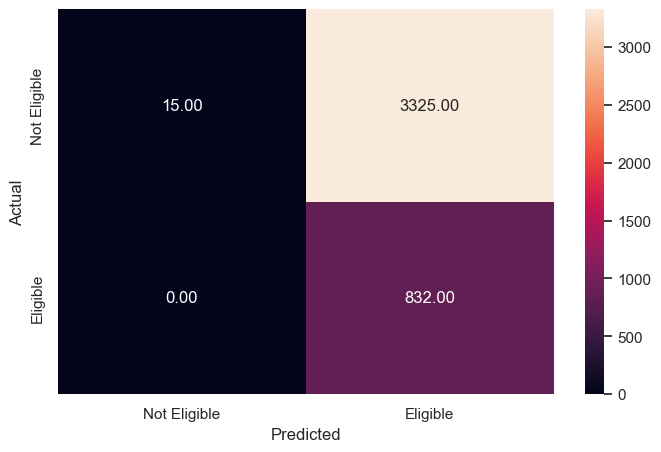

In [78]:
# Checking performance on the training data
y_pred_train9 = svc_tuned.predict(X_train_scaled)

metrics_score(y_train, y_pred_train9)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1431
           1       0.20      1.00      0.33       357

    accuracy                           0.20      1788
   macro avg       0.60      0.50      0.17      1788
weighted avg       0.84      0.20      0.08      1788



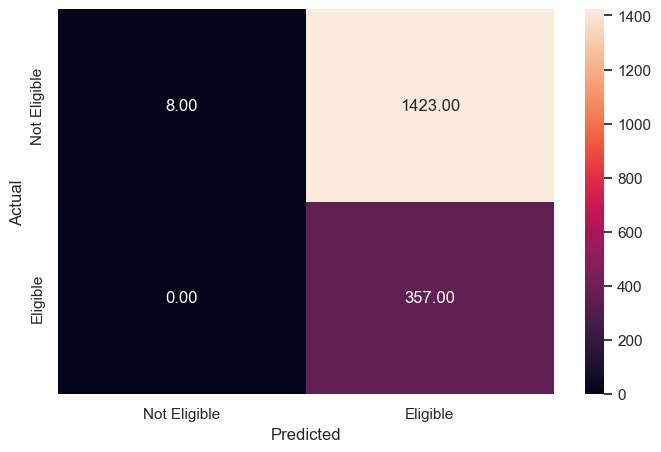

In [79]:
# Checking performance on the test data
y_pred_test9 = svc_tuned.predict(X_test_scaled)

metrics_score(y_test, y_pred_test9)

<ul>
    <li>SVC with a Gaussian Kernel is not overfitting the training set at all.</li>
    <li>SVC provides an amazing perfect score on Recall, which is the metric of main interest</li>
    <li>Unfortunately, the cost in terms of loss in Precision is too big. This model is capable of just 20% Precision on unseen data.</li>
    <li>The F1-score is only 33% on test set, which is the lowest of all models seen so far.</li>
    <li>Let's explore the performance at the equilibrium to check if managing the PR trade-off can help.</li>
</ul>

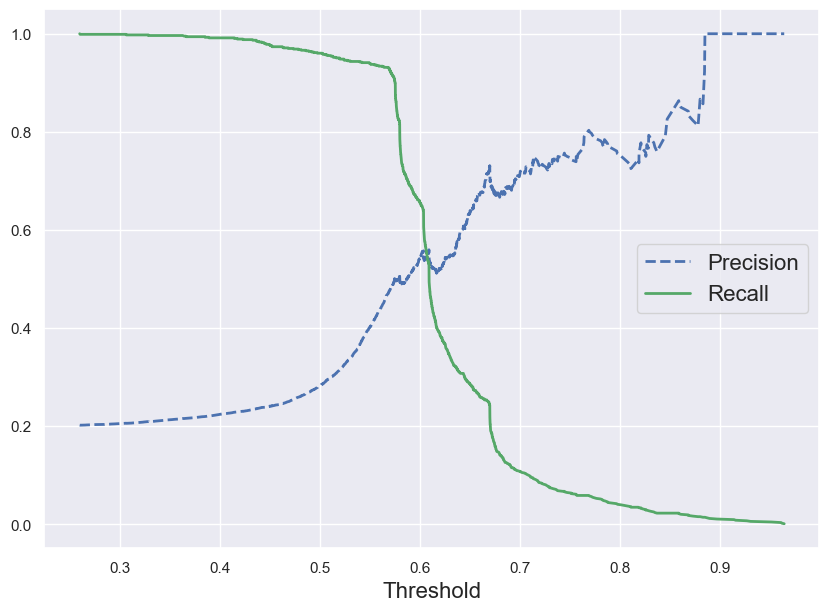

In [80]:
# The code for precision recall curve for SVC is different as it does not have the predict_proba method
y_scores_svc=cross_val_predict(svc_tuned,X_train_scaled,y_train,cv=5,method="decision_function")
precisions,recalls,thresholds=precision_recall_curve(y_train,y_scores_svc)
plt.figure(figsize = (10, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)      
plt.grid(True)                                                                          

<ul>
<li>Recall curve falls really abruptly in range [.55-65]. meaning that recall is very high till till .55 than decreases a lot, thus making nearly impossible to find a good compromise between Precision and Recall.</li>
<li>The precision after .55 is not smooth, meaning that beyond that threshold by proceeding at small steps the metrics is not always increasing each time.</li>
<li>The equilibrium is located ad a threshold of about 0.6</li>
</ul>

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3340
           1       0.54      0.54      0.54       832

    accuracy                           0.82      4172
   macro avg       0.72      0.71      0.71      4172
weighted avg       0.82      0.82      0.82      4172



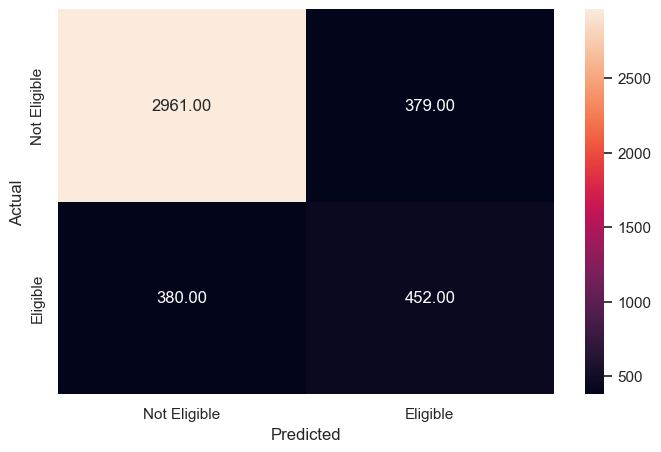

In [81]:
opt_threshold=.6075

metrics_score(y_train,y_scores_svc>opt_threshold)

<ul>
<li>Precision and Recall at the equilibrium are only 54%, much lower than LDA and Logistic Regression models.</li>
<li>Managin the trade-off between Precision and recall is difficult due to slope of Recall curve.</li>
</ul>

In [82]:
# Adding the SVC model to candidate model collection
candidateModels=addModel(svc_tuned,X_train_scaled,X_test_scaled,candidateModels)

### **Building a K Nearest Neighbours Model**

#### Using GridSearchCV for Hyperparameter tuning on the model

In [83]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals 
knn_tuned = KNeighborsClassifier()

# Grid of parameters to choose from
parameters ={"n_neighbors":np.arange(1,15),
             "weights":['uniform','distance'],
             "p":[1,2]
            }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search
grid_obj = GridSearchCV(knn_tuned, parameters, scoring = scorer, cv = 20)


#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train_scaled, y_train)


# Set the clf to the best combination of parameters
knn_tuned = grid_obj.best_estimator_


# Fit the best algorithm to the data. 
knn_tuned .fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1, p=1)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



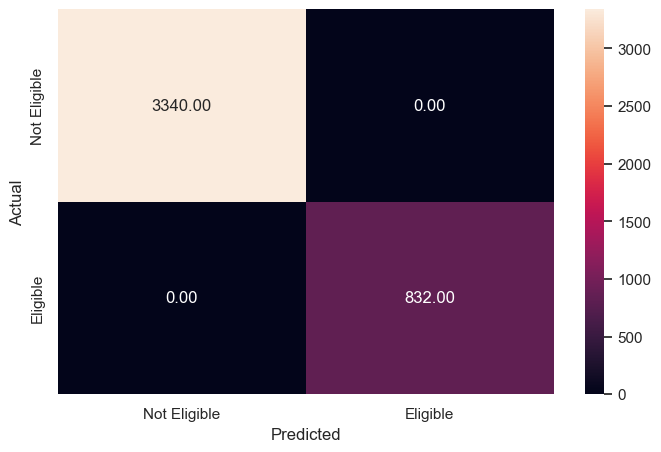

In [84]:
y_pred_train10 = knn_tuned.predict(X_train_scaled)

metrics_score(y_train, y_pred_train10)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1431
           1       0.93      0.79      0.85       357

    accuracy                           0.95      1788
   macro avg       0.94      0.89      0.91      1788
weighted avg       0.94      0.95      0.94      1788



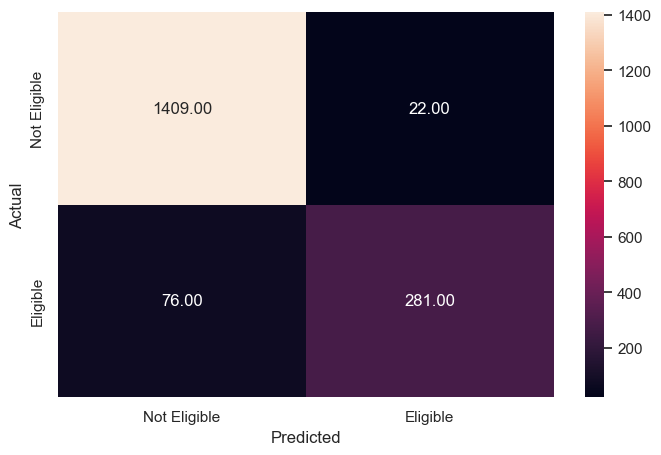

In [85]:
# Checking performance on the test data
y_pred_test10 = knn_tuned.predict(X_test_scaled)

metrics_score(y_test, y_pred_test10)

<ul>
    <li>The knn approach is based on the idea of instance-based learning by memorizing the training set, thus it tends to have high variance.</li> 
    <li>Hyperparameter tuning returns n_neighbors=1, meaning that only the closest instance is considered in order to produce inferences, with a high probability of capturing the noise.</li>
    <li>The model here is doing perfectly on the training set, however Recall and Precision are significantly lower on the test set. Here there is strong overfitting.</li>
    
</ul>

In [86]:
# Adding the knn model to candidate model collection
candidateModels=addModel(knn_tuned,X_train_scaled,X_test_scaled,candidateModels)

### **Boosting**
One disadvantage of boosting is that it is sensitive to outliers since every classifier is obliged to fix the errors in the predecessors.<br>Therefore, this class of models will be trained on the dataset obrained after outlier treatment.

In [87]:
# Drop the dependent variable from the dataframe and create the X(independent variable) matrix
X=data.drop(columns='BAD')

# Create dummy variables for the categorical variables - Hint: use the get_dummies() function
X=pd.get_dummies(X,drop_first=True)

# Create y(dependent varibale)
Y=data.BAD

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1, stratify=Y)

### **Building an AdaBoost Model**


**learning_reate**<br>
Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier

#### Using RandomizedSearchCV for Hyperparameter tuning on the base model

In [88]:
"""
d_tree_AB= DecisionTreeClassifier(random_state = 7)
distributions={"criterion":['gini','entropy'],
              "min_samples_split":range(1,60),
              "min_samples_leaf": range(5,100),
              "max_features":['auto', 'sqrt', 'log2', None],
              "max_depth":range(5,100),
              "class_weight":[{0:.2,1:.8},"balanced"]
              }

scorer = metrics.make_scorer(recall_score, pos_label = 1)

clf = RandomizedSearchCV(d_tree_AB, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)
search = clf.fit(X_train,y_train)
search.best_params_
"""

'\nd_tree_AB= DecisionTreeClassifier(random_state = 7)\ndistributions={"criterion":[\'gini\',\'entropy\'],\n              "min_samples_split":range(1,60),\n              "min_samples_leaf": range(5,100),\n              "max_features":[\'auto\', \'sqrt\', \'log2\', None],\n              "max_depth":range(5,100),\n              "class_weight":[{0:.2,1:.8},"balanced"]\n              }\n\nscorer = metrics.make_scorer(recall_score, pos_label = 1)\n\nclf = RandomizedSearchCV(d_tree_AB, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)\nsearch = clf.fit(X_train,y_train)\nsearch.best_params_\n'

#### Using GridSearchCV for Hyperparameter tuning on the base model around the values found with RandomizedSearchCV

In [89]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals 
d_tree_AB = DecisionTreeClassifier(criterion="entropy",class_weight="balanced",random_state=8)


# Grid of parameters to choose from
parameters = {'min_samples_split':range(1,3),
              'min_samples_leaf': np.arange(35,40),
              'max_depth': np.arange(10,15)               
             }


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search
grid_obj = GridSearchCV(d_tree_AB, parameters, scoring = scorer, cv = 5)


# Fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train, y_train)


# Set the clf to the best combination of parameters
d_tree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=38, random_state=8)

#### Using RandomizedSearchCV for Hyperparameter tuning on the model trying random combinations

In [90]:
"""
AB_tuned = AdaBoostClassifier(d_tree_AB,random_state = 7)
distributions={"algorithm":['SAMME','SAMME.R'],
              "n_estimators": range(100,300),
               "learning_rate":np.linspace(.8,2.5,30)
              }

scorer = metrics.make_scorer(recall_score, pos_label = 1)

clf = RandomizedSearchCV(AB_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)
search = clf.fit(X_train,y_train)
search.best_params_
"""

'\nAB_tuned = AdaBoostClassifier(d_tree_AB,random_state = 7)\ndistributions={"algorithm":[\'SAMME\',\'SAMME.R\'],\n              "n_estimators": range(100,300),\n               "learning_rate":np.linspace(.8,2.5,30)\n              }\n\nscorer = metrics.make_scorer(recall_score, pos_label = 1)\n\nclf = RandomizedSearchCV(AB_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)\nsearch = clf.fit(X_train,y_train)\nsearch.best_params_\n'

#### Using GridSearchCV for Hyperparameter tuning on the model around the values found with RandomizedSearchCV

In [91]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals 
AB_tuned = AdaBoostClassifier(d_tree_AB,algorithm='SAMME',random_state=7)

# Grid of parameters to choose from
parameters ={"n_estimators":[139,140,141],
             "learning_rate":np.linspace(0,.01,5)
            } 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(AB_tuned, parameters, scoring = scorer, cv = 5)

#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
AB_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
AB_tuned .fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         random_state=8),
                   learning_rate=0.0025, n_estimators=139, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



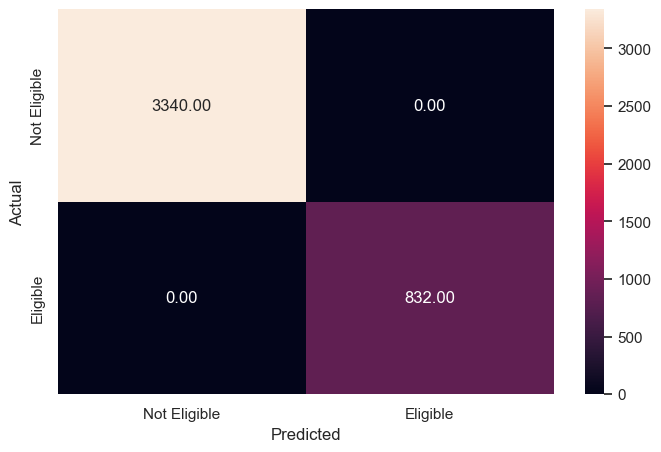

In [92]:
# Checking performance on the training data
y_pred_train11 = AB_tuned.predict(X_train)

metrics_score(y_train, y_pred_train11)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1431
           1       0.90      0.84      0.87       357

    accuracy                           0.95      1788
   macro avg       0.93      0.91      0.92      1788
weighted avg       0.95      0.95      0.95      1788



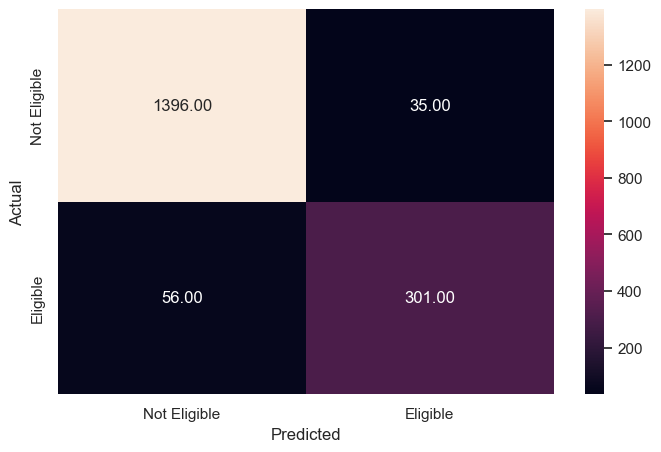

In [93]:
# Checking performance on the test data
y_pred_test11 = AB_tuned.predict(X_test)

metrics_score(y_test, y_pred_test11)

<ul>
    <li>Precision scores are 100%-90% and those for Recall are 100%-84% on train and test set respectively.</li>
    <li>This model is overfitting the training data due to significative higher performance on train set than test set. </li>
</ul>

In [94]:
# Adding the AdaBoost model to candidate model collection
candidateModels=addModel(AB_tuned,X_train,X_test,candidateModels)

### **Building a GradientBoosting Model**

#### Using RandomizedSearchCV for Hyperparameter tuning on the model trying random combinations

In [95]:
"""
GB_tuned = GradientBoostingClassifier(random_state = 7)
distributions={"n_estimators": range(10,500),
              "min_samples_split":range(1,5),
              "min_samples_leaf": range(5,100),
              "max_features":['auto', 'sqrt', 'log2', None],
              "max_depth":range(5,100),
               "learning_rate":np.linspace(.1,1.5,30)
              }

scorer = metrics.make_scorer(recall_score, pos_label = 1)

clf = RandomizedSearchCV(GB_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)
search = clf.fit(X_train,y_train)
search.best_params_
"""

'\nGB_tuned = GradientBoostingClassifier(random_state = 7)\ndistributions={"n_estimators": range(10,500),\n              "min_samples_split":range(1,5),\n              "min_samples_leaf": range(5,100),\n              "max_features":[\'auto\', \'sqrt\', \'log2\', None],\n              "max_depth":range(5,100),\n               "learning_rate":np.linspace(.1,1.5,30)\n              }\n\nscorer = metrics.make_scorer(recall_score, pos_label = 1)\n\nclf = RandomizedSearchCV(GB_tuned, distributions, random_state=1,scoring=scorer,cv=5,n_iter=30)\nsearch = clf.fit(X_train,y_train)\nsearch.best_params_\n'

#### Using GridSearchCV for Hyperparameter tuning on the model around the values found with RandomizedSearchCV

In [96]:
# Choose the type of classifier. This grid was defined after severl steps of searches on different intervals  
GB_tuned = GradientBoostingClassifier(random_state=7,
                                      min_samples_split=2,
                                      min_samples_leaf=60,
                                      max_depth=20,
                                      max_features='sqrt'
                                     )

# Grid of parameters to choose from
parameters ={"n_estimators":[120,130,140],
             "learning_rate":[.9,.95,1]
            } 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(GB_tuned, parameters, scoring = scorer, cv = 5)

#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
GB_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data 
GB_tuned .fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.95, max_depth=20,
                           max_features='sqrt', min_samples_leaf=60,
                           n_estimators=130, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



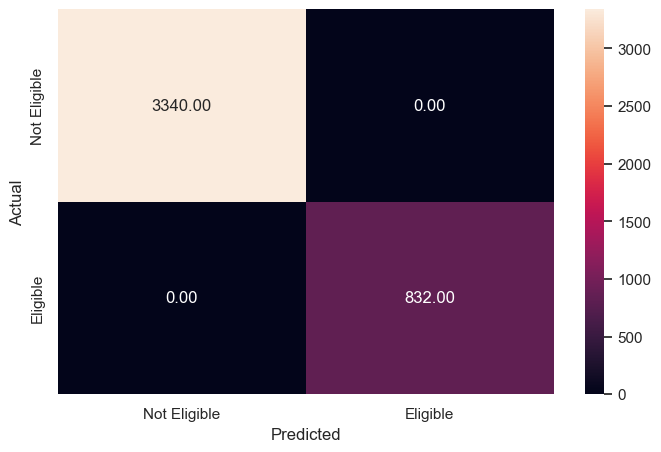

In [97]:
# Checking performance on the training data
y_pred_train12 = GB_tuned.predict(X_train)

metrics_score(y_train, y_pred_train12)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1431
           1       0.99      0.86      0.92       357

    accuracy                           0.97      1788
   macro avg       0.98      0.93      0.95      1788
weighted avg       0.97      0.97      0.97      1788



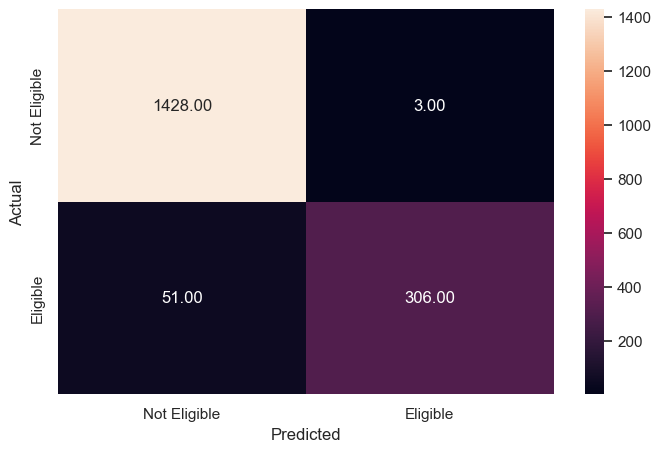

In [98]:
y_pred_test12 = GB_tuned.predict(X_test)

metrics_score(y_test, y_pred_test12)

<ul>
    <li>Precision and Recall scores are perfect on train set, while they are 99% and 86% respectively on test set.</li>
    <li>This model is overfitting the training data due to significative higher Recall score on train set.</li>
</ul>

In [99]:
# Adding the GradientBoosting model to candidate model collection
candidateModels=addModel(GB_tuned,X_train,X_test,candidateModels)

### **Building an Artificial Neural Network Model**

In [100]:
# NNs are impacted by outliers if they are not too deep. Therefore, the dataset with treated outliers is needed.

# Setting the random seed for reproducible results
np.random.seed(12)
random.seed(12)
tf.random.set_seed(12)

# Crete a Sequential Object
ANN= Sequential()
# Add the input layer
ANN.add(InputLayer(input_shape=(X_train_scaled.shape[1],)))
# Add batch normalization layer
ANN.add(BatchNormalization())
# Add first dense layer with 100 neurons to the sequental object
ANN.add(Dense(100,use_bias=False,kernel_initializer='he_normal'))
# Add batch normalization layer
ANN.add(BatchNormalization())
# Add Relu activation function
ANN.add(ReLU())
# Add dropout layer
ANN.add(Dropout(.03))
# Add second layer with 100 neurons to the sequental object
ANN.add(Dense(100,use_bias=False,kernel_initializer='he_normal'))
# Add batch normalization layer
ANN.add(BatchNormalization())
# Add Relu activation function
ANN.add(ReLU())
# Add dropout layer
ANN.add(Dropout(.03))
# Output layer with 10 neurons as it has 10 classes
ANN.add(Dense(1, activation = 'sigmoid'))

In [101]:
# Print Summary of the model
ANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 27)               108       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               2700      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               1

In [102]:
# Compile the model
ANN.compile(loss = 'binary_crossentropy',
              metrics = ['accuracy'],
              optimizer = "adam")

In [103]:
# Set the number of epochs for training
num_epochs = 200

# Set the batch size for training
batch_size = 64

# Define the early stopping to prevent overfitting coming from overtraining
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history=ANN.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs = num_epochs, batch_size = batch_size, class_weight={0: 0.2, 1: 0.8},callbacks=[callback],verbose = 1)

Epoch 1/200
66/66 [==============================] - 2s 7ms/step - loss: 0.1462 - accuracy: 0.7804 - val_loss: 0.5227 - val_accuracy: 0.7847
Epoch 2/200
66/66 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.8646 - val_loss: 0.4399 - val_accuracy: 0.8166
Epoch 3/200
66/66 [==============================] - 0s 5ms/step - loss: 0.1018 - accuracy: 0.8823 - val_loss: 0.3782 - val_accuracy: 0.8356
Epoch 4/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0976 - accuracy: 0.8806 - val_loss: 0.3190 - val_accuracy: 0.8658
Epoch 5/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0932 - accuracy: 0.8941 - val_loss: 0.3015 - val_accuracy: 0.8736
Epoch 6/200
66/66 [==============================] - 1s 9ms/step - loss: 0.0841 - accuracy: 0.9041 - val_loss: 0.2505 - val_accuracy: 0.9083
Epoch 7/200
66/66 [==============================] - 1s 12ms/step - loss: 0.0818 - accuracy: 0.9039 - val_loss: 0.2638 - val_accuracy: 0.8881
Epoch 8/200


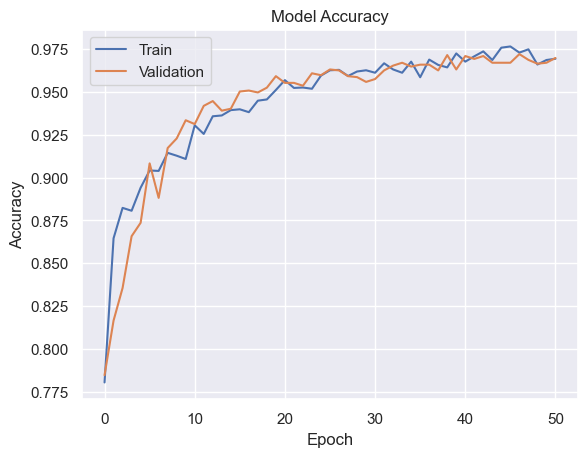

In [104]:
# Plotting train and test learning curves
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

<ul>
<li>The learning curves have a good trend as they tend to flatten with the validation curve slightly below the train one, however they are bumpy.</li> 
<li>The accuracy obtained after 51 epochs is similar in training and test set as both curves reached a plateu at good accuracy.</li>
</ul>

#### Checking the performance on the train dataset

In [105]:
probToClass=lambda x:1 if x>.5 else 0

131/131 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       0.99      0.98      0.99       832

    accuracy                           0.99      4172
   macro avg       0.99      0.99      0.99      4172
weighted avg       0.99      0.99      0.99      4172



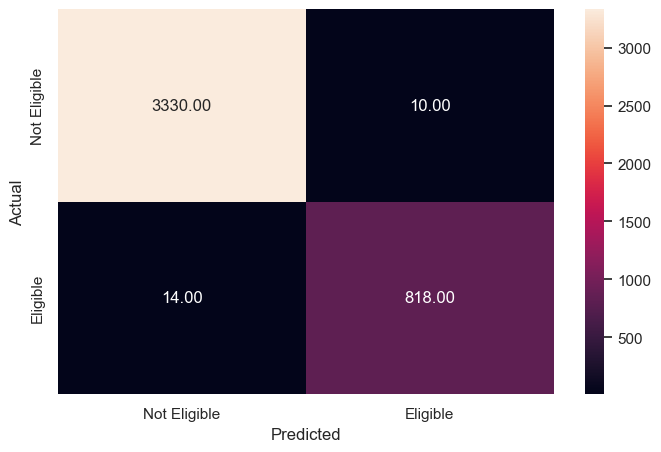

In [106]:
y_pred_train13 = ANN.predict(X_train_scaled)

metrics_score(y_train,list(map(probToClass,y_pred_train13)))

#### Checking the performance on the test dataset

56/56 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1431
           1       0.96      0.89      0.92       357

    accuracy                           0.97      1788
   macro avg       0.97      0.94      0.95      1788
weighted avg       0.97      0.97      0.97      1788



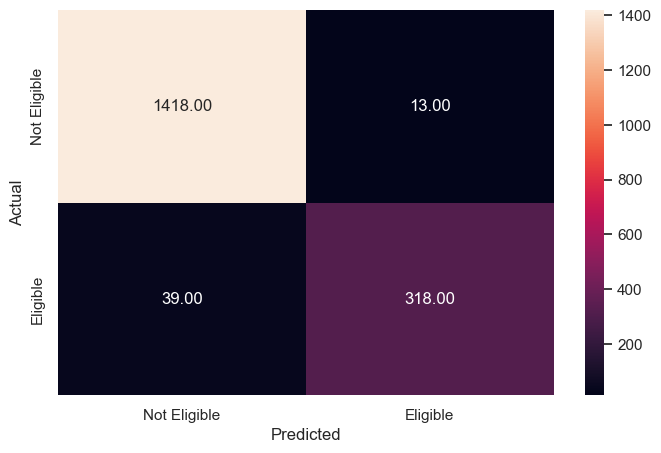

In [107]:
y_pred_test13 = ANN.predict(X_test_scaled)

metrics_score(y_test, list(map(probToClass,y_pred_test13)))

<ul>
<li>From a closer inspection, the artificial neural network model is strongly overfitting the training set: the gap in the Recall is 9%.</li>
<li>Furthermore, ANN is not an interpretable model.</li>
</ul>

In [108]:
metrics_=[accuracy_score(y_train,list(map(probToClass,y_pred_train13))),
         accuracy_score(y_test,list(map(probToClass,y_pred_test13))),
         recall_score(y_train,list(map(probToClass,y_pred_train13))),
         recall_score(y_test,list(map(probToClass,y_pred_test13))),
         precision_score(y_train,list(map(probToClass,y_pred_train13))),
         precision_score(y_test,list(map(probToClass,y_pred_test13)))
         ]
candidateModels=candidateModels.append(pd.DataFrame(data=metrics_,index=columns,columns=["ArtificialNeuralNetwork_"]).T)

### **Comparing Model Performances**

In [109]:
candidateModels

,trainAcc,testAcc,trainRec,testRec,trainPre,testPre
LogisticRegression_,0.864094,0.864094,0.824519,0.806723,0.619693,0.623377
Probit_,0.518563,0.440716,0.641916,0.633053,0.514890,0.206393
DecisionTreeClassifier_,1.000000,0.946309,1.000000,0.848739,1.000000,0.878261
DecisionTreeClassifier_tuned,0.920662,0.896532,0.899038,0.823529,0.751759,0.706731
RandomForestClassifier_,1.000000,0.963647,1.000000,0.817927,1.000000,1.000000
RandomForestClassifier_w,1.000000,0.958054,1.000000,0.789916,1.000000,1.000000
RandomForestClassifier_tuned,0.976750,0.955817,0.905048,0.809524,0.976654,0.963333
LinearDiscriminantAnalysis_,0.900767,0.897651,0.687500,0.663866,0.787879,0.790000
QuadraticDiscriminantAnalysis_,0.865772,0.873043,0.649038,0.591036,0.668317,0.722603
SVC_,0.203020,0.204139,1.000000,1.000000,0.200144,0.200562


Observations were already drawn in more detail for each mode and are hereby summarized:
<ul>  
<li>Logistic Regression is not overfitting tha training set. It is capable to use fewer variables keeping almost unchanged the predictive power, thus retaining most information and getting rid of pointless complexity at the same time. Moreover, the contribution of each variable in the predictions can be easily verified looking at coefficients.</li>
<li>Probit is overall the worst performer of all linear models since it provides only 21% Precision and 63% Recall on unseen data.</li>
<li>Decision Tree is strongly overfitting training data as all performance on test set are significantly worse; consequently its use in production is not recommended.</li>
<li>Even if Decision Tree hyperparameter tuning attempted at avoiding overfitting, the problem is not entirely solved as the train/test gap on Recall is 8%. Still not suggested to be used in production.</li>
<li>Random Forest has a similar behaviour to Decision Trees and if unconstrained tends to overfit the training set. Regularization is needed.</li>
<li>Random Forest with class weights is surprisingly performing slightly worse than the default one.</li>
<li>Random Forest after extensive hyperparameter tuning seems at a first sight to perform well. However, at a close look there is a gap of 10% on Recall between train and test set, meaning that overfitting is still too strong to become a first choice model.</li>
<li>Linear Discriminant Analysis seems performing similarly to Logistic Regression. However, the first uses 26 predictors while the latter uses barely 16. At a give performance, the simpler model is better.</li>
<li>Quadratic Discriminant Analysis is not a good candidate as it provides only 72% Precision and 59% Recall on unseen data.</li>
<li>SVC has a big inbalance in the performance on each metric. Anyhow, at the equilibrium it reaches a lower performance compared to Logistic Regression or LDA. Furthermore, its predictions are slow. It is definetly the worst model.</li>
<li>KNeighborsClassifier is strongly overfitting the training set. Hyperparameter tuning found that the best number of neighbours is 1, therefore the model has high variance and high chance to capture the noise in the training data. Moreover, as the number of instances becomes larger, it becomes slower in predicting at deployment time.</li>
<li>AdaBoostClassifier and GradientBoostingClassifiers are both powerful ensemble learning methods, but in this case are overfitting the training set.</li>
</ul> 

## **Customized classifiers**

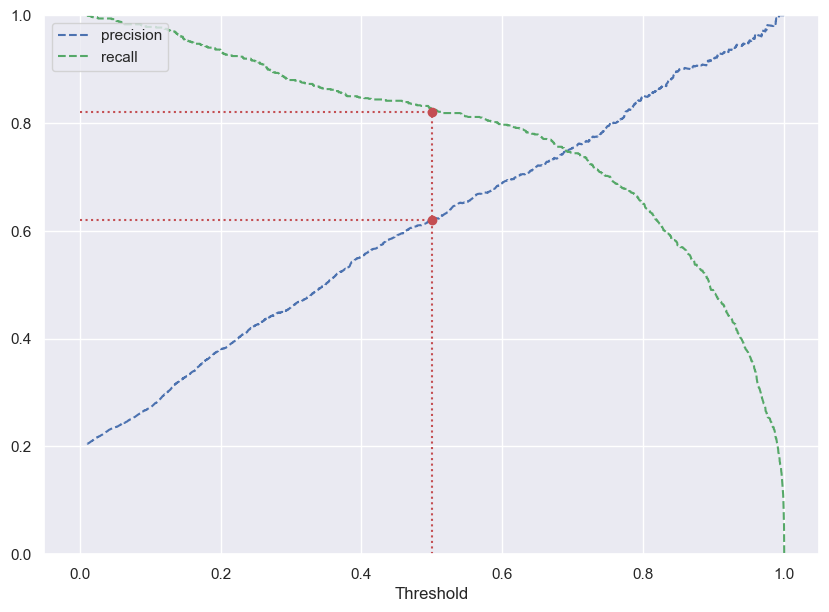

In [110]:
# Current logistic regression has a threshold of .5
base_threshold=.5
PrecisionRecall_curve(X_train_scaled__,lg3)
plt.plot([base_threshold,base_threshold], [0, 0.82], "r:")                 
plt.plot([0, base_threshold], [0.62, 0.62], "r:")                                
plt.plot([0, base_threshold], [0.82,0.82], "r:")
plt.plot([base_threshold], [0.62], "ro")                                             
plt.plot([base_threshold], [0.82], "ro") 

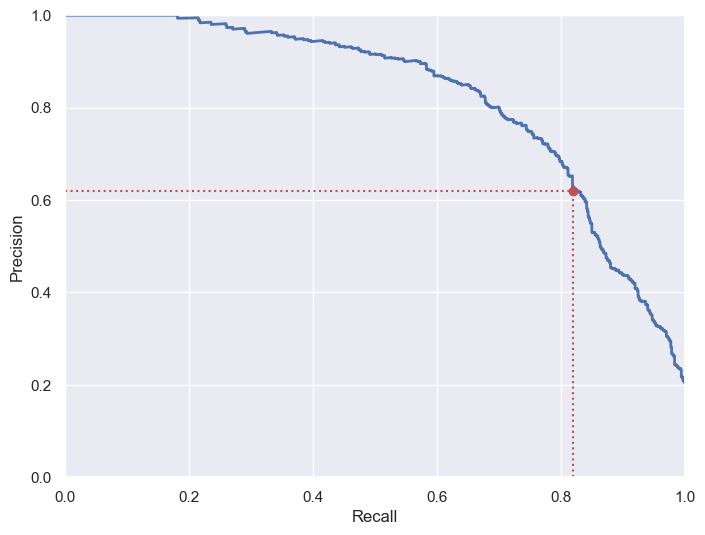

In [111]:
def plot_precision_vs_recall():
    precisions,recalls,thresholds= precision_recall_curve(y_train, y_scores[:, 1])
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall()
plt.plot([.82,.82],[0,.62], "r:")
plt.plot([.0,.82],[.62,.62], "r:")
plt.plot([.82],[.62], "ro")

Logistic regression with the default threshold reaches 62% Precision and 82% Recall.

              precision    recall  f1-score   support

           0       0.97      0.72      0.82      3340
           1       0.44      0.90      0.59       832

    accuracy                           0.75      4172
   macro avg       0.70      0.81      0.71      4172
weighted avg       0.86      0.75      0.78      4172



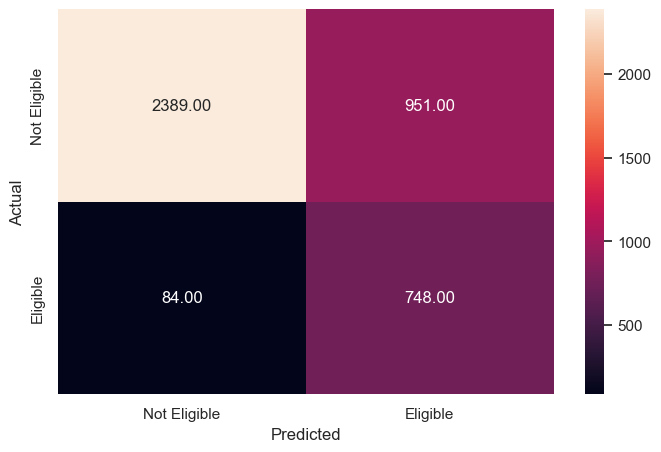

In [112]:
# Finding the 90% recall threshold
threshold_90_recall=.27

metrics_score(y_train,y_scores[:,1]>threshold_90_recall)

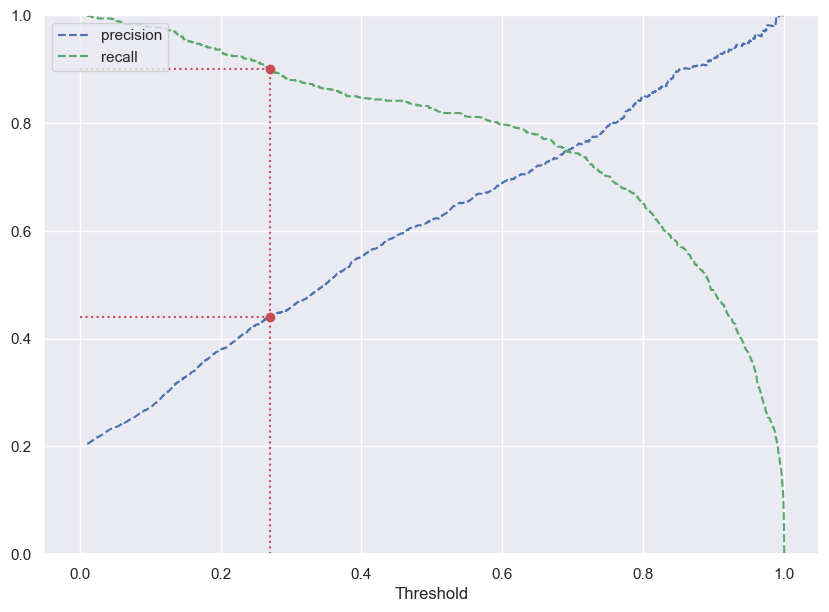

In [113]:
# Customized classifier with 90% recall
PrecisionRecall_curve(X_train_scaled__,lg3)
plt.plot([threshold_90_recall, threshold_90_recall], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_recall], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_recall], [0.44,0.44], "r:")
plt.plot([threshold_90_recall], [0.9], "ro")                                             
plt.plot([threshold_90_recall], [0.44], "ro")  

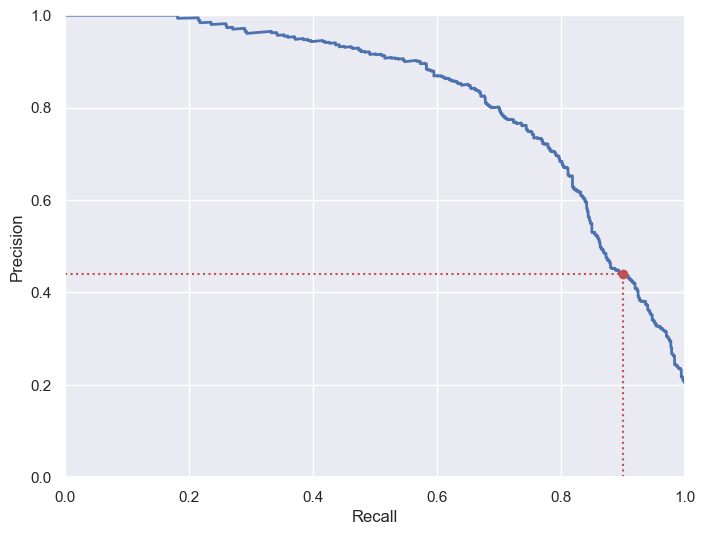

In [114]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall()
plt.plot([.9,.9],[0,.44], "r:")
plt.plot([0,.9],[.44,.44], "r:")
plt.plot([.9], [.44], "ro")

The classifier reaching 90% recall requires a huge loss in precision (44%).

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3340
           1       0.90      0.57      0.70       832

    accuracy                           0.90      4172
   macro avg       0.90      0.78      0.82      4172
weighted avg       0.90      0.90      0.89      4172



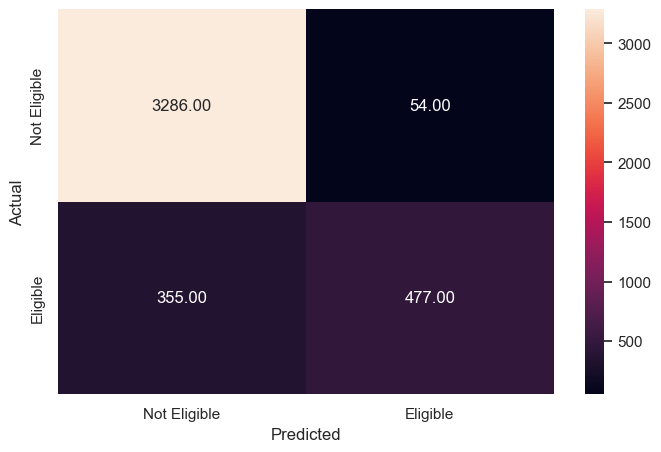

In [115]:
# Finding the 90% precision threshold
threshold_90_precision=.85

metrics_score(y_train,y_scores[:,1]>threshold_90_precision)

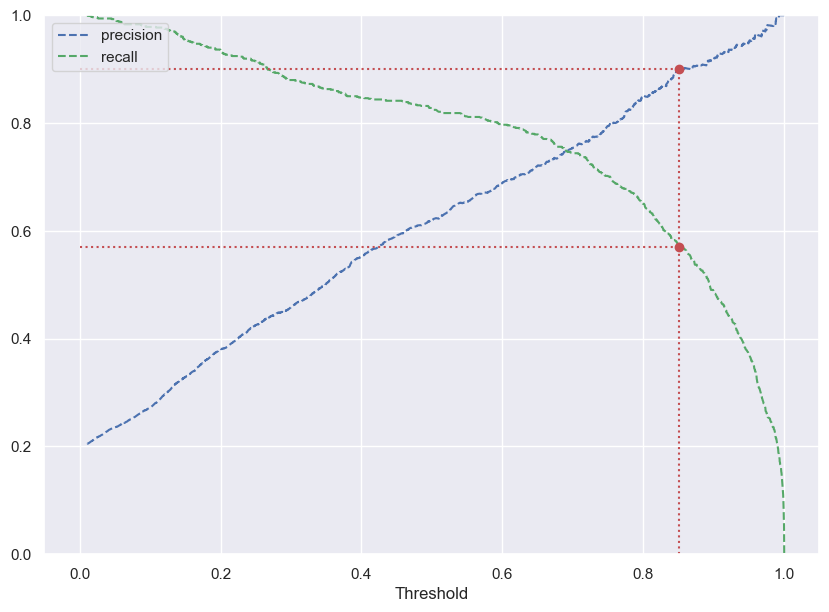

In [116]:
# Customized classifier with 90% precision
PrecisionRecall_curve(X_train_scaled__,lg3)
plt.plot([threshold_90_precision,threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_precision], [0.57,0.57], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [0.57], "ro") 

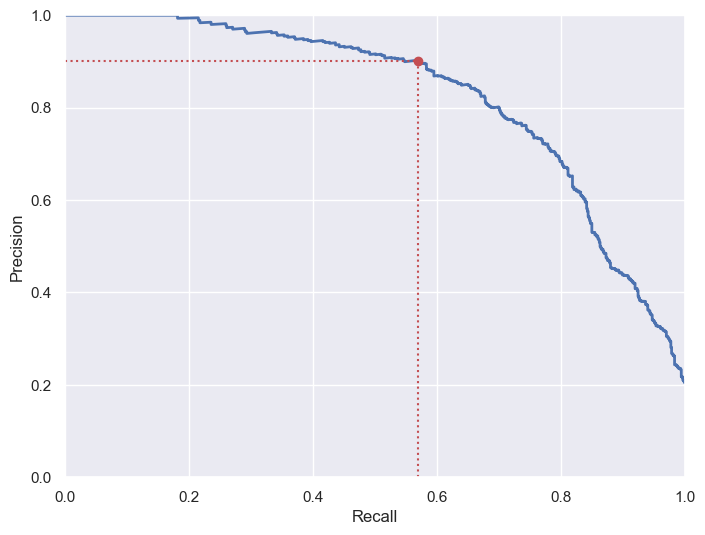

In [117]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall()
plt.plot([.57,.57],[0,.9], "r:")
plt.plot([0,.57],[.9,.9], "r:")
plt.plot([.57], [.9], "ro")

The classifier reaching 90% precision requires a relevant loss in recall (57%).

The classifiers above are extreme examples prioritizing a lot one metric over the other.<br>
A more reasonable classifier to be put into production could be one maximizing Recall whilst providing at least 70% Precision. 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3340
           1       0.70      0.80      0.74       832

    accuracy                           0.89      4172
   macro avg       0.82      0.85      0.84      4172
weighted avg       0.90      0.89      0.89      4172



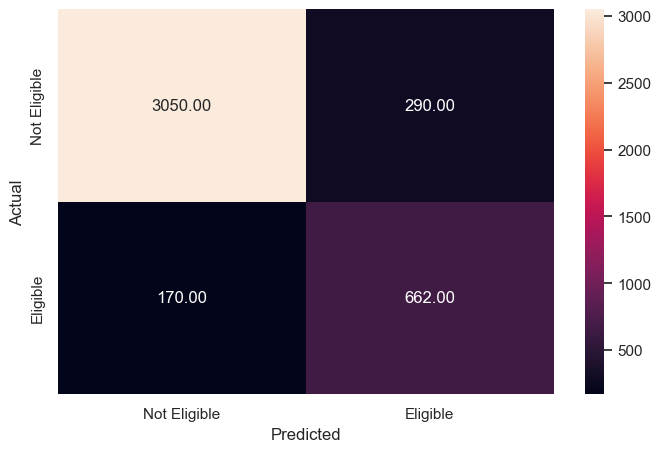

In [118]:
# Finding the 65% precision threshold
threshold_70_precision=.61

metrics_score(y_train,y_scores[:,1]>threshold_70_precision)

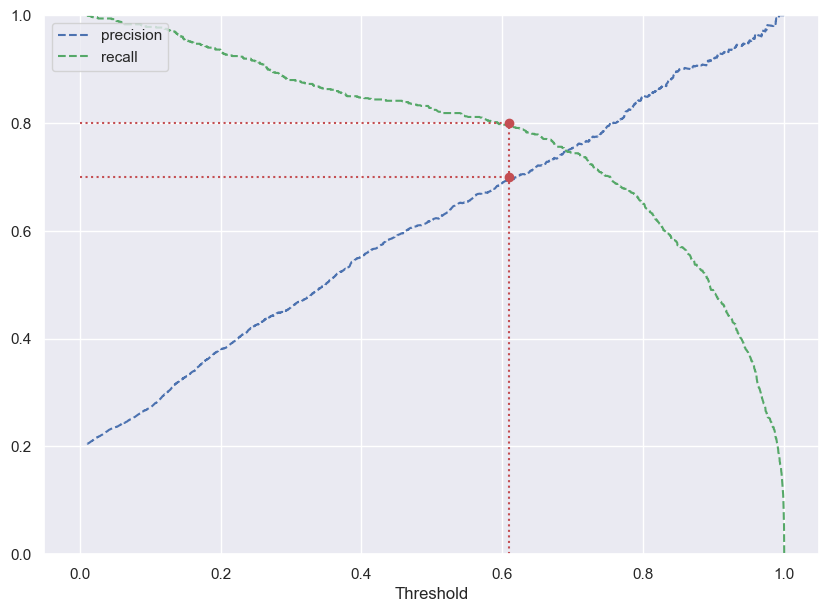

In [119]:
# Customized classifier with 70% precision
PrecisionRecall_curve(X_train_scaled__,lg3)
plt.plot([threshold_70_precision,threshold_70_precision], [0., 0.8], "r:")                 
plt.plot([0, threshold_70_precision], [0.7, 0.7], "r:")                                
plt.plot([0, threshold_70_precision], [0.8,0.8], "r:")
plt.plot([threshold_70_precision], [0.7], "ro")                                             
plt.plot([threshold_70_precision], [0.8], "ro")  

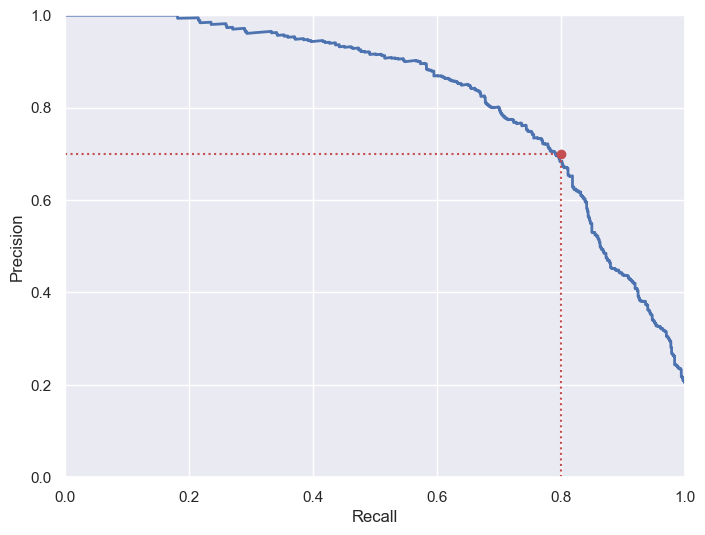

In [120]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall()
plt.plot([.8,.8],[0,.7], "r:")
plt.plot([0,.8],[.7,.7], "r:")
plt.plot([.8], [.7], "ro")